In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, joblib, statistics
import sklearn as sk
import optuna
import xgboost as xgb
import plotly
import json
import math
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GroupKFold
from typing import List, Optional, Tuple
import functions
from tabulate import tabulate

random.seed(1213870)

### LOADING IN ALL DATASETS AND PREPARING THEM

In [6]:
# data for model training 
path1 = ('../data/Preprop_data_w_folds')

data_MatchingGame = pd.read_csv(os.path.join(path1,'MatchingGame_w_folds.csv'), delimiter=';')
data_Questions_fam = pd.read_csv(os.path.join(path1, 'Questions_fam_w_folds.csv'), delimiter=';')
data_Questions_unfam = pd.read_csv(os.path.join(path1, 'Questions_unfam_w_folds.csv'), delimiter=';')



In [2]:
# data for model testing
path2 = ('../data/test_sets')

MG_MG_20 = pd.read_csv(os.path.join(path2,'MG/test_MatchingGame_20.csv'), delimiter=';')
MG_Qfam_20 = pd.read_csv(os.path.join(path2,'MG/test_Questions_fam_20.csv'), delimiter=';')
MG_Qfam_80 = pd.read_csv(os.path.join(path2,'MG/test_Questions_fam_80.csv'), delimiter=';')
Qfam_MG_20 = pd.read_csv(os.path.join(path2,'Qfam/test_MatchingGame_20.csv'), delimiter=';')
Qfam_MG_80 = pd.read_csv(os.path.join(path2,'Qfam/test_MatchingGame_80.csv'), delimiter=';')
Qfam_Qfam_20 = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_fam_20.csv'), delimiter=';')
Qfam_Qunfam_20 = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_unfam_20.csv'), delimiter=';')
Qfam_Qunfam_80 = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_unfam_80.csv'), delimiter=';')
Qunfam_Qfam_20 = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_fam_20.csv'), delimiter=';')
Qunfam_Qfam_80 = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_fam_80.csv'), delimiter=';')
Qunfam_Qunfam_20 = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_unfam_20.csv'), delimiter=';')


In [3]:
# loading the feature lists
path3 = ('../data/feature_lists')

MG_features = pd.read_csv(os.path.join(path3,'MatchingGame_featurelist.csv'), delimiter=';')
Qfam_features = pd.read_csv(os.path.join(path3, 'Questions_fam_featurelist.csv'), delimiter=';')
Qunfam_features = pd.read_csv(os.path.join(path3, 'Questions_unfam_featurelist.csv'), delimiter=';')

In [7]:
# cleaning feature lists
functions.clean_features(MG_features, feature_list=True)
functions.clean_features(Qfam_features, feature_list=True)
functions.clean_features(Qunfam_features, feature_list=True)

# cleaning model training data
functions.clean_features(data_MatchingGame, feature_list = False)
functions.clean_features(data_Questions_fam, feature_list = False)
functions.clean_features(data_Questions_unfam, feature_list = False)

# cleaning test data
functions.clean_features(MG_MG_20, feature_list = False)
functions.clean_features(MG_Qfam_20, feature_list = False)
functions.clean_features(MG_Qfam_80, feature_list = False)
functions.clean_features(Qfam_MG_20, feature_list = False)
functions.clean_features(Qfam_MG_80, feature_list = False)
functions.clean_features(Qfam_Qfam_20, feature_list = False)
functions.clean_features(Qfam_Qunfam_20, feature_list = False)
functions.clean_features(Qfam_Qunfam_80, feature_list = False)
functions.clean_features(Qunfam_Qfam_20, feature_list = False)
functions.clean_features(Qunfam_Qfam_80, feature_list = False)
functions.clean_features(Qunfam_Qunfam_20, feature_list = False)


,median_F0final_sma,iqr_F0final_sma,median_voicingFinalUnclipped_sma,iqr_voicingFinalUnclipped_sma,median_jitterLocal_sma,iqr_jitterLocal_sma,median_jitterDDP_sma,iqr_jitterDDP_sma,median_shimmerLocal_sma,iqr_shimmerLocal_sma,...,iqr_mfcc_sma_de_11_,median_mfcc_sma_de_12_,iqr_mfcc_sma_de_12_,median_mfcc_sma_de_13_,iqr_mfcc_sma_de_13_,median_mfcc_sma_de_14_,iqr_mfcc_sma_de_14_,utterance_length,Diagnosis,ID
0,0.303231,0.108704,0.502144,0.835377,0.026343,0.123811,0.020299,0.105973,0.160442,0.312577,...,0.371626,0.518333,0.302256,0.396466,0.368206,0.463973,0.384397,0.098330,0,9611
1,0.260783,0.101097,0.653211,0.383666,0.021077,0.022190,0.020098,0.022383,0.103584,0.140880,...,0.282255,0.497142,0.335026,0.435754,0.321891,0.491925,0.404899,0.336207,0,9611
2,0.320001,0.062155,0.677215,0.884880,0.037941,0.090081,0.029462,0.138858,0.091119,0.369198,...,0.521192,0.506412,0.487988,0.422888,0.181943,0.509181,0.544741,0.071390,0,9611
3,0.259548,0.033698,0.767221,0.182358,0.017083,0.013999,0.016759,0.015936,0.085533,0.065614,...,0.186120,0.527404,0.289932,0.465167,0.221046,0.502223,0.226692,0.164781,0,9611
4,0.229530,0.015952,0.764407,0.208216,0.016090,0.016374,0.015124,0.017554,0.073327,0.063334,...,0.243267,0.555483,0.273139,0.457529,0.211052,0.465493,0.357992,0.090338,0,9611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,0.378669,0.131196,0.593775,0.254098,0.030057,0.025177,0.032243,0.023951,0.104500,0.085221,...,0.492774,0.565756,0.425799,0.447915,0.319424,0.499205,0.345846,0.119612,1,9795
3771,0.281573,0.094892,0.543637,0.391300,0.029904,0.049573,0.034030,0.045259,0.105900,0.161729,...,0.373334,0.539068,0.254839,0.465514,0.292250,0.468034,0.468639,0.226473,1,9795
3772,0.268596,0.072960,0.409935,0.391503,0.060665,0.057163,0.073796,0.049728,0.156550,0.170607,...,0.513214,0.514956,0.352729,0.363946,0.326063,0.456537,0.390571,0.130119,1,9795
3773,0.308245,0.393642,0.282741,0.637794,0.104317,0.089215,0.099860,0.088509,0.368260,0.373852,...,0.277646,0.611109,0.424392,0.478582,0.339883,0.438622,0.297590,0.037626,1,9795


# XGB

In [7]:
# HYPERPARAMETERTUNING
# NO NEED TO RUN ANYMORE: VALUES ARE SAVED AND CAN BE RUN INTO WD IN CHUNK UNDERNEATH
bestparams_MG_xgb = functions.parametertuner(model_type = 'xgb', train = data_MatchingGame, feature_lists = MG_features, train_name = 'MatchingGame', trials = 100, jobs = 32)

[I 2024-11-29 11:27:49,422] A new study created in memory with name: no-name-d6b32c24-cec7-449a-a4d0-ed245bde0b8f


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
22

2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
3
4
3
3
4
3
4
3
3
4
33

3
4
3
3
3
3
4
3
4
4
4
4
4
4
4
5
5
4
5
5
5
5
5
5
5
4
4
4
5
4
4
5
4
4
4


[I 2024-11-29 11:28:58,146] Trial 21 finished with value: 0.568879052367017 and parameters: {'learning_rate': 0.2073312646780842, 'reg_lambda': 2.47251123016114e-06, 'max_depth': 3, 'min_child_weight': 82, 'gamma': 3.9979523310708527, 'reg_alpha': 2.1128622942763107}. Best is trial 21 with value: 0.568879052367017.


1
4
5


[I 2024-11-29 11:28:59,333] Trial 1 finished with value: 0.5699555107970479 and parameters: {'learning_rate': 0.21837634224075156, 'reg_lambda': 1.3022970258917799e-07, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.19909541007413378, 'reg_alpha': 0.06471306608156438}. Best is trial 1 with value: 0.5699555107970479.


5
5
14

5
4
4


[I 2024-11-29 11:29:01,079] Trial 2 finished with value: 0.5651986248093253 and parameters: {'learning_rate': 0.10879885764079511, 'reg_lambda': 0.0013064124365871255, 'max_depth': 3, 'min_child_weight': 35, 'gamma': 0.8880193386638874, 'reg_alpha': 3.586042965970471e-05}. Best is trial 1 with value: 0.5699555107970479.
[I 2024-11-29 11:29:01,243] Trial 26 finished with value: 0.5531536424031465 and parameters: {'learning_rate': 0.03652075202299591, 'reg_lambda': 0.009270205197953425, 'max_depth': 3, 'min_child_weight': 49, 'gamma': 1.6051526173038138, 'reg_alpha': 0.07463944095387588}. Best is trial 1 with value: 0.5699555107970479.
[I 2024-11-29 11:29:01,336] Trial 16 finished with value: 0.5559972268476967 and parameters: {'learning_rate': 0.04568143190601592, 'reg_lambda': 0.00011637120909873067, 'max_depth': 3, 'min_child_weight': 79, 'gamma': 4.637207563252051, 'reg_alpha': 6.381841507023856}. Best is trial 1 with value: 0.5699555107970479.


1
1
4
1
5


[I 2024-11-29 11:29:02,606] Trial 29 finished with value: 0.5743073189511874 and parameters: {'learning_rate': 0.2908290286463837, 'reg_lambda': 0.0030540234009357736, 'max_depth': 4, 'min_child_weight': 89, 'gamma': 4.120824268781854, 'reg_alpha': 3.0940988764911894e-08}. Best is trial 29 with value: 0.5743073189511874.


5
4
1


[I 2024-11-29 11:29:02,797] Trial 24 finished with value: 0.5692595329942528 and parameters: {'learning_rate': 0.2873955200358833, 'reg_lambda': 0.43826721683024783, 'max_depth': 3, 'min_child_weight': 12, 'gamma': 1.6032276125634874, 'reg_alpha': 7.120627214771819e-05}. Best is trial 29 with value: 0.5743073189511874.


1
5


[I 2024-11-29 11:29:04,205] Trial 17 finished with value: 0.5719787057853727 and parameters: {'learning_rate': 0.26241443672578274, 'reg_lambda': 19.365736744505963, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 4.073357082552818, 'reg_alpha': 3.766579208070416e-07}. Best is trial 29 with value: 0.5743073189511874.


1


[I 2024-11-29 11:29:05,623] Trial 28 finished with value: 0.5683902514332037 and parameters: {'learning_rate': 0.27694845867112594, 'reg_lambda': 0.13701072119631508, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 3.126809974754097, 'reg_alpha': 4.1108835830041314e-07}. Best is trial 29 with value: 0.5743073189511874.


1


[I 2024-11-29 11:29:06,360] Trial 5 finished with value: 0.5739211270125483 and parameters: {'learning_rate': 0.26098936364314806, 'reg_lambda': 0.140931650164321, 'max_depth': 4, 'min_child_weight': 61, 'gamma': 1.6853043233241576, 'reg_alpha': 4.749311467029698e-08}. Best is trial 29 with value: 0.5743073189511874.


1


[I 2024-11-29 11:29:07,535] Trial 7 finished with value: 0.5721498638567305 and parameters: {'learning_rate': 0.24338030364002058, 'reg_lambda': 0.6007791162138905, 'max_depth': 10, 'min_child_weight': 89, 'gamma': 3.824446836036107, 'reg_alpha': 4.5768563084134936e-08}. Best is trial 29 with value: 0.5743073189511874.


1
5


[I 2024-11-29 11:29:13,248] Trial 31 finished with value: 0.5664294811815095 and parameters: {'learning_rate': 0.24438677224025998, 'reg_lambda': 8.618102001197747e-06, 'max_depth': 5, 'min_child_weight': 44, 'gamma': 0.3261260911421343, 'reg_alpha': 0.0006890763112783253}. Best is trial 29 with value: 0.5743073189511874.


5
5
1


[I 2024-11-29 11:29:13,864] Trial 4 finished with value: 0.5714008545834208 and parameters: {'learning_rate': 0.16679997014591183, 'reg_lambda': 2.378086804604788e-05, 'max_depth': 9, 'min_child_weight': 67, 'gamma': 4.398596727149571, 'reg_alpha': 1.8228616452223136e-08}. Best is trial 29 with value: 0.5743073189511874.


2


[I 2024-11-29 11:29:14,046] Trial 8 finished with value: 0.5670976163304536 and parameters: {'learning_rate': 0.22520651532171718, 'reg_lambda': 7.667670250659816e-08, 'max_depth': 5, 'min_child_weight': 60, 'gamma': 1.9888718610192897, 'reg_alpha': 0.0015756216682919128}. Best is trial 29 with value: 0.5743073189511874.
[I 2024-11-29 11:29:14,460] Trial 12 finished with value: 0.5655847070491088 and parameters: {'learning_rate': 0.19734925152391933, 'reg_lambda': 1.53511895269521e-08, 'max_depth': 5, 'min_child_weight': 66, 'gamma': 2.787045538152771, 'reg_alpha': 3.880128831777595e-05}. Best is trial 29 with value: 0.5743073189511874.


1
1
5
1
5
2
5
2
2


[I 2024-11-29 11:29:17,808] Trial 18 finished with value: 0.56656362473587 and parameters: {'learning_rate': 0.1912307708044418, 'reg_lambda': 1.6905304767597495e-08, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.3258004078098453, 'reg_alpha': 1.950832428668201}. Best is trial 29 with value: 0.5743073189511874.


5
5
1
2


[I 2024-11-29 11:29:18,222] Trial 13 finished with value: 0.574267320241743 and parameters: {'learning_rate': 0.146030018912369, 'reg_lambda': 0.00026728022730645816, 'max_depth': 10, 'min_child_weight': 65, 'gamma': 4.299092590490725, 'reg_alpha': 4.845161947341718e-08}. Best is trial 29 with value: 0.5743073189511874.


2
2
1
5


[I 2024-11-29 11:29:19,759] Trial 30 finished with value: 0.5714391733793815 and parameters: {'learning_rate': 0.1840266253149894, 'reg_lambda': 5.904842419371785, 'max_depth': 6, 'min_child_weight': 97, 'gamma': 1.224681298921032, 'reg_alpha': 3.4794483115419322e-06}. Best is trial 29 with value: 0.5743073189511874.


2
1
5
2
5
5
5
2
2
5


[I 2024-11-29 11:29:24,890] Trial 27 finished with value: 0.5602784332526 and parameters: {'learning_rate': 0.021934045529431463, 'reg_lambda': 5.089676233782215e-08, 'max_depth': 6, 'min_child_weight': 25, 'gamma': 3.108529337120307, 'reg_alpha': 3.840797917681195e-08}. Best is trial 29 with value: 0.5743073189511874.


1


[I 2024-11-29 11:29:27,370] Trial 22 finished with value: 0.5715130926244554 and parameters: {'learning_rate': 0.21106422298416863, 'reg_lambda': 0.3725721406065348, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 1.4414861426707688, 'reg_alpha': 2.2618042073543144e-08}. Best is trial 29 with value: 0.5743073189511874.


1
3
2
2
2


[I 2024-11-29 11:29:30,648] Trial 14 finished with value: 0.5705057734391288 and parameters: {'learning_rate': 0.10657374312137947, 'reg_lambda': 23.399966646394976, 'max_depth': 7, 'min_child_weight': 49, 'gamma': 1.0730687284677014, 'reg_alpha': 1.9297456603911678e-05}. Best is trial 29 with value: 0.5743073189511874.


1
2
3


[I 2024-11-29 11:29:32,624] Trial 3 finished with value: 0.570714500987591 and parameters: {'learning_rate': 0.11544454433986624, 'reg_lambda': 9.701987373151752, 'max_depth': 8, 'min_child_weight': 66, 'gamma': 1.8728516020978159, 'reg_alpha': 4.646790725143746e-06}. Best is trial 29 with value: 0.5743073189511874.


3


[I 2024-11-29 11:29:32,966] Trial 10 finished with value: 0.5656529963390171 and parameters: {'learning_rate': 0.08581050673151548, 'reg_lambda': 1.7071815136668744, 'max_depth': 7, 'min_child_weight': 27, 'gamma': 0.6422873335264206, 'reg_alpha': 0.007889156292193968}. Best is trial 29 with value: 0.5743073189511874.


1
3
3
1
3


[I 2024-11-29 11:29:34,171] Trial 23 finished with value: 0.5737048828811971 and parameters: {'learning_rate': 0.060377468329449395, 'reg_lambda': 2.8138505663106776e-06, 'max_depth': 10, 'min_child_weight': 92, 'gamma': 0.015508060422793624, 'reg_alpha': 0.00683662437634092}. Best is trial 29 with value: 0.5743073189511874.


3
1
2


[I 2024-11-29 11:29:36,041] Trial 6 finished with value: 0.5740076328464427 and parameters: {'learning_rate': 0.08127778108962262, 'reg_lambda': 2.230265141048655e-06, 'max_depth': 9, 'min_child_weight': 46, 'gamma': 3.2063758415347077, 'reg_alpha': 2.7605722417425063}. Best is trial 29 with value: 0.5743073189511874.
[I 2024-11-29 11:29:36,571] Trial 9 finished with value: 0.5703459023830818 and parameters: {'learning_rate': 0.06472003565571222, 'reg_lambda': 0.00047058473426368416, 'max_depth': 9, 'min_child_weight': 54, 'gamma': 4.5824509639384, 'reg_alpha': 0.9066600781210837}. Best is trial 29 with value: 0.5743073189511874.


2
1
2
1


[I 2024-11-29 11:29:37,417] Trial 0 finished with value: 0.5644525826909303 and parameters: {'learning_rate': 0.023396337387030064, 'reg_lambda': 5.77716028314549e-06, 'max_depth': 8, 'min_child_weight': 41, 'gamma': 0.4436771371208875, 'reg_alpha': 0.03481251168579726}. Best is trial 29 with value: 0.5743073189511874.


3


[I 2024-11-29 11:29:38,259] Trial 11 finished with value: 0.5707921988329827 and parameters: {'learning_rate': 0.20470602842770722, 'reg_lambda': 2.1171338177845858, 'max_depth': 9, 'min_child_weight': 36, 'gamma': 1.0804988484052125, 'reg_alpha': 7.983171705344033e-07}. Best is trial 29 with value: 0.5743073189511874.


1
1


[I 2024-11-29 11:29:39,606] Trial 15 finished with value: 0.5652384684783138 and parameters: {'learning_rate': 0.028509944278989646, 'reg_lambda': 0.00288023357886249, 'max_depth': 9, 'min_child_weight': 54, 'gamma': 0.2030048630698683, 'reg_alpha': 0.08956607646010845}. Best is trial 29 with value: 0.5743073189511874.
[I 2024-11-29 11:29:39,713] Trial 20 finished with value: 0.5696477122553774 and parameters: {'learning_rate': 0.08854313292292801, 'reg_lambda': 0.08273530906361112, 'max_depth': 10, 'min_child_weight': 62, 'gamma': 1.2568450604468433, 'reg_alpha': 0.006085272289708261}. Best is trial 29 with value: 0.5743073189511874.


3


[I 2024-11-29 11:29:40,112] Trial 19 finished with value: 0.5710891951578347 and parameters: {'learning_rate': 0.08660095614710908, 'reg_lambda': 4.597973440521812, 'max_depth': 10, 'min_child_weight': 50, 'gamma': 2.1304428901595474, 'reg_alpha': 3.061504737775043e-08}. Best is trial 29 with value: 0.5743073189511874.


1
3
1
1
3
2


[I 2024-11-29 11:29:41,329] Trial 25 finished with value: 0.5685084632842966 and parameters: {'learning_rate': 0.09108185566183334, 'reg_lambda': 1.3555688740724334e-07, 'max_depth': 10, 'min_child_weight': 31, 'gamma': 0.06689820407689118, 'reg_alpha': 3.581589549444601e-07}. Best is trial 29 with value: 0.5743073189511874.


4
1
2
3
2
3
3
4
2
4
2
4
3
4
2
4
4
2
2
3
4
3
2
3
2
2
4
5
2
4
2
2
4
3
3
4
3
4
5
3
4
5
5
5
3
3
4
3
5
5
3
5
3


[I 2024-11-29 11:30:07,650] Trial 36 finished with value: 0.5527705915181744 and parameters: {'learning_rate': 0.04325449231838168, 'reg_lambda': 3.940626481780399e-05, 'max_depth': 3, 'min_child_weight': 96, 'gamma': 1.3690206653204444, 'reg_alpha': 11.646009061706692}. Best is trial 29 with value: 0.5743073189511874.


4
4
1
3
3
3
5
4
3
5


[I 2024-11-29 11:30:12,858] Trial 37 finished with value: 0.5737684363890129 and parameters: {'learning_rate': 0.2097467069643794, 'reg_lambda': 0.26024758825515576, 'max_depth': 4, 'min_child_weight': 66, 'gamma': 0.508528548126625, 'reg_alpha': 0.5783122304121296}. Best is trial 29 with value: 0.5743073189511874.


53

4


[I 2024-11-29 11:30:13,140] Trial 40 finished with value: 0.5667067863763425 and parameters: {'learning_rate': 0.18607280310978985, 'reg_lambda': 2.6587151468612548e-06, 'max_depth': 3, 'min_child_weight': 24, 'gamma': 1.3522988487883658, 'reg_alpha': 0.004940261835415387}. Best is trial 29 with value: 0.5743073189511874.
[I 2024-11-29 11:30:13,376] Trial 39 finished with value: 0.5689691079041987 and parameters: {'learning_rate': 0.26932002688679807, 'reg_lambda': 0.04483819841463881, 'max_depth': 4, 'min_child_weight': 31, 'gamma': 2.617427538511138, 'reg_alpha': 1.2069888107459976e-07}. Best is trial 29 with value: 0.5743073189511874.


1
4
1
1
4


[I 2024-11-29 11:30:15,030] Trial 34 finished with value: 0.5667172056796062 and parameters: {'learning_rate': 0.1767244924956584, 'reg_lambda': 0.01102784245771012, 'max_depth': 7, 'min_child_weight': 75, 'gamma': 1.8304643587492464, 'reg_alpha': 20.727226511589556}. Best is trial 29 with value: 0.5743073189511874.


5
5
1
4
5
4
4


[I 2024-11-29 11:30:17,939] Trial 38 finished with value: 0.5747485865064379 and parameters: {'learning_rate': 0.24520250122215811, 'reg_lambda': 0.010762087315823855, 'max_depth': 8, 'min_child_weight': 62, 'gamma': 3.0699842856920236, 'reg_alpha': 4.905217819815962e-08}. Best is trial 38 with value: 0.5747485865064379.


5
1


[I 2024-11-29 11:30:19,375] Trial 32 finished with value: 0.5689311063413294 and parameters: {'learning_rate': 0.26721864623236946, 'reg_lambda': 1.9548948439541788e-05, 'max_depth': 6, 'min_child_weight': 74, 'gamma': 0.0002726210717701738, 'reg_alpha': 0.08865217662428862}. Best is trial 38 with value: 0.5747485865064379.


4
4
4
1


[I 2024-11-29 11:30:21,036] Trial 33 finished with value: 0.5708788323867126 and parameters: {'learning_rate': 0.05493475034033754, 'reg_lambda': 0.00017121046844719475, 'max_depth': 6, 'min_child_weight': 76, 'gamma': 4.447457785448493, 'reg_alpha': 0.012495143108718187}. Best is trial 38 with value: 0.5747485865064379.


2
1
5
4
4


[I 2024-11-29 11:30:24,504] Trial 41 finished with value: 0.575114711370307 and parameters: {'learning_rate': 0.15465934799105713, 'reg_lambda': 1.5562745671988797e-05, 'max_depth': 6, 'min_child_weight': 95, 'gamma': 3.0659098510192595, 'reg_alpha': 5.2706398304041235e-06}. Best is trial 41 with value: 0.575114711370307.


4
5
1


[I 2024-11-29 11:30:25,182] Trial 42 finished with value: 0.5698689859104565 and parameters: {'learning_rate': 0.16252258771881586, 'reg_lambda': 4.7080292633612475e-05, 'max_depth': 6, 'min_child_weight': 68, 'gamma': 2.534789001399605, 'reg_alpha': 1.3109426778189173e-08}. Best is trial 41 with value: 0.575114711370307.


1


[I 2024-11-29 11:30:26,260] Trial 44 finished with value: 0.571637201056658 and parameters: {'learning_rate': 0.2986141463939378, 'reg_lambda': 0.00868613681201257, 'max_depth': 5, 'min_child_weight': 98, 'gamma': 2.6383141410058095, 'reg_alpha': 3.067154773332117e-06}. Best is trial 41 with value: 0.575114711370307.


4
5
5
2
1
2
2
5


[I 2024-11-29 11:30:28,762] Trial 43 finished with value: 0.5689251678119502 and parameters: {'learning_rate': 0.1689508099608651, 'reg_lambda': 0.010636630662380941, 'max_depth': 5, 'min_child_weight': 67, 'gamma': 2.5503490731542806, 'reg_alpha': 1.1709592674923903e-08}. Best is trial 41 with value: 0.575114711370307.
[I 2024-11-29 11:30:29,288] Trial 45 finished with value: 0.5672809781854886 and parameters: {'learning_rate': 0.16889983956835847, 'reg_lambda': 0.006133773017838074, 'max_depth': 5, 'min_child_weight': 100, 'gamma': 2.9367882554185183, 'reg_alpha': 2.0598804372920066e-06}. Best is trial 41 with value: 0.575114711370307.


4
2
1
5
1
5
5


[I 2024-11-29 11:30:31,362] Trial 46 finished with value: 0.5763479921756518 and parameters: {'learning_rate': 0.29932351637842114, 'reg_lambda': 0.007875204200071772, 'max_depth': 7, 'min_child_weight': 97, 'gamma': 2.2839519930144965, 'reg_alpha': 5.156918705801303e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:30:31,532] Trial 35 finished with value: 0.5661444396370272 and parameters: {'learning_rate': 0.2616902320905292, 'reg_lambda': 0.14906908124531898, 'max_depth': 8, 'min_child_weight': 21, 'gamma': 0.24147210676951358, 'reg_alpha': 0.0007440792246377897}. Best is trial 46 with value: 0.5763479921756518.


5
1
5
1
2
5
2
5


[I 2024-11-29 11:30:35,335] Trial 49 finished with value: 0.5747124218213984 and parameters: {'learning_rate': 0.11892286870950278, 'reg_lambda': 0.0023060213898118765, 'max_depth': 7, 'min_child_weight': 98, 'gamma': 4.912952397844968, 'reg_alpha': 1.2680819442629609e-06}. Best is trial 46 with value: 0.5763479921756518.


2
3
1
5
5
5


[I 2024-11-29 11:30:38,816] Trial 52 finished with value: 0.5734882721925485 and parameters: {'learning_rate': 0.1331478733166343, 'reg_lambda': 0.007250373588157837, 'max_depth': 4, 'min_child_weight': 76, 'gamma': 4.851577657983447, 'reg_alpha': 5.048277457016649e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:30:39,061] Trial 47 finished with value: 0.5710725922603538 and parameters: {'learning_rate': 0.10854735885644667, 'reg_lambda': 0.007556225987160892, 'max_depth': 7, 'min_child_weight': 92, 'gamma': 3.2883196183234933, 'reg_alpha': 1.8387736112929999e-06}. Best is trial 46 with value: 0.5763479921756518.


2
1
1


[I 2024-11-29 11:30:40,424] Trial 53 finished with value: 0.5726770179778318 and parameters: {'learning_rate': 0.14985650097483452, 'reg_lambda': 0.008750743722906709, 'max_depth': 4, 'min_child_weight': 78, 'gamma': 4.901983305523419, 'reg_alpha': 2.9223344860884197e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:30:40,625] Trial 48 finished with value: 0.5762953792722822 and parameters: {'learning_rate': 0.11492538008367041, 'reg_lambda': 0.0025172620610337043, 'max_depth': 8, 'min_child_weight': 99, 'gamma': 3.3168800910235805, 'reg_alpha': 1.7423725689132106e-06}. Best is trial 46 with value: 0.5763479921756518.


2
3
2
3
1
15

3
3


[I 2024-11-29 11:30:43,123] Trial 55 finished with value: 0.5726854987219175 and parameters: {'learning_rate': 0.14120405204384517, 'reg_lambda': 0.01815864866668858, 'max_depth': 4, 'min_child_weight': 79, 'gamma': 4.9710941674320805, 'reg_alpha': 1.8633551558208368e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:30:43,626] Trial 54 finished with value: 0.5729576743694376 and parameters: {'learning_rate': 0.13769461798696336, 'reg_lambda': 0.01826405146791554, 'max_depth': 4, 'min_child_weight': 76, 'gamma': 2.4082935234844074, 'reg_alpha': 4.5905205429955845e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:30:44,344] Trial 51 finished with value: 0.5697217101714379 and parameters: {'learning_rate': 0.1202795458997534, 'reg_lambda': 0.0032701523242066547, 'max_depth': 8, 'min_child_weight': 100, 'gamma': 4.80792162680101, 'reg_alpha': 1.8735071256151471e-06}. Best is trial 46 with value: 0.5763479921756518.


1
5
2


[I 2024-11-29 11:30:44,752] Trial 61 finished with value: 0.5699126762472406 and parameters: {'learning_rate': 0.13504798393274214, 'reg_lambda': 4.6812030681896316e-07, 'max_depth': 4, 'min_child_weight': 75, 'gamma': 3.564351861753499, 'reg_alpha': 17.162126456927687}. Best is trial 46 with value: 0.5763479921756518.


1
2
1
2
1


[I 2024-11-29 11:30:46,998] Trial 50 finished with value: 0.5707583918056877 and parameters: {'learning_rate': 0.11346170592331398, 'reg_lambda': 0.0023340619261008177, 'max_depth': 8, 'min_child_weight': 77, 'gamma': 3.6262618589173408, 'reg_alpha': 9.078018760357353e-07}. Best is trial 46 with value: 0.5763479921756518.


2
3


[I 2024-11-29 11:30:47,309] Trial 56 finished with value: 0.5741626302604865 and parameters: {'learning_rate': 0.14600406039460948, 'reg_lambda': 0.003886704851569483, 'max_depth': 9, 'min_child_weight': 77, 'gamma': 4.963998729660597, 'reg_alpha': 6.996048529097039e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:30:47,555] Trial 57 finished with value: 0.5752249211197669 and parameters: {'learning_rate': 0.1384217797922859, 'reg_lambda': 0.009719541106568917, 'max_depth': 9, 'min_child_weight': 76, 'gamma': 4.960042646555484, 'reg_alpha': 3.3801414768432544e-07}. Best is trial 46 with value: 0.5763479921756518.


1
1
4
1
3


[I 2024-11-29 11:30:50,023] Trial 63 finished with value: 0.570416041476671 and parameters: {'learning_rate': 0.13848871827599454, 'reg_lambda': 0.020297301505371193, 'max_depth': 4, 'min_child_weight': 71, 'gamma': 3.6203581423741777, 'reg_alpha': 1.1538683409060275e-07}. Best is trial 46 with value: 0.5763479921756518.


3
2


[I 2024-11-29 11:30:50,418] Trial 62 finished with value: 0.5733652014963325 and parameters: {'learning_rate': 0.1262469215333697, 'reg_lambda': 0.01851162134697883, 'max_depth': 4, 'min_child_weight': 76, 'gamma': 3.4822674317897695, 'reg_alpha': 1.440057619191218e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:30:50,995] Trial 58 finished with value: 0.573596066015443 and parameters: {'learning_rate': 0.15186303063555773, 'reg_lambda': 0.006644115747354338, 'max_depth': 9, 'min_child_weight': 77, 'gamma': 3.564209746105823, 'reg_alpha': 3.1261131471549534e-07}. Best is trial 46 with value: 0.5763479921756518.


1
1
1
2
2
3
4
4
3


[I 2024-11-29 11:30:56,035] Trial 59 finished with value: 0.5713667370906117 and parameters: {'learning_rate': 0.13962250640338048, 'reg_lambda': 0.0165241953408392, 'max_depth': 9, 'min_child_weight': 79, 'gamma': 3.5842878800551174, 'reg_alpha': 0.0001916209427317323}. Best is trial 46 with value: 0.5763479921756518.


4
3
1
4
2
2


[I 2024-11-29 11:30:58,923] Trial 60 finished with value: 0.5726991113764337 and parameters: {'learning_rate': 0.1408652117321935, 'reg_lambda': 0.03063310744309161, 'max_depth': 10, 'min_child_weight': 76, 'gamma': 3.4661097067791333, 'reg_alpha': 2.006904509870755e-07}. Best is trial 46 with value: 0.5763479921756518.


2
2
3
1
2
3
2
4
2
3
3
5
2
42

2
4
3
2
2
3
3
5
4
4
5
2
5
5
4
2
3
3
3
3
4
4


[I 2024-11-29 11:31:16,051] Trial 64 finished with value: 0.5666080835259552 and parameters: {'learning_rate': 0.13786673736538466, 'reg_lambda': 0.024774272413084508, 'max_depth': 4, 'min_child_weight': 80, 'gamma': 3.5199001776818193, 'reg_alpha': 1.1511144205647231e-07}. Best is trial 46 with value: 0.5763479921756518.


1
5
3
3
3
4
3
3
4
5


[I 2024-11-29 11:31:20,254] Trial 65 finished with value: 0.5714461681535992 and parameters: {'learning_rate': 0.13152543085761578, 'reg_lambda': 0.018347369523257197, 'max_depth': 4, 'min_child_weight': 77, 'gamma': 3.3902852532393, 'reg_alpha': 1.324579308768542e-07}. Best is trial 46 with value: 0.5763479921756518.


3
4
3
5
4
1
3


[I 2024-11-29 11:31:22,327] Trial 67 finished with value: 0.5717373846478224 and parameters: {'learning_rate': 0.13768143946832018, 'reg_lambda': 0.0094765701789031, 'max_depth': 4, 'min_child_weight': 79, 'gamma': 3.587041246221337, 'reg_alpha': 1.125079261957006e-08}. Best is trial 46 with value: 0.5763479921756518.


4
1
5


[I 2024-11-29 11:31:24,159] Trial 68 finished with value: 0.5718060315391987 and parameters: {'learning_rate': 0.13696922249984156, 'reg_lambda': 0.001012417654010102, 'max_depth': 4, 'min_child_weight': 72, 'gamma': 3.5727532609777612, 'reg_alpha': 3.915248269349724e-06}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:24,494] Trial 66 finished with value: 0.5710941664518302 and parameters: {'learning_rate': 0.1439790979976853, 'reg_lambda': 0.02631064503284047, 'max_depth': 4, 'min_child_weight': 77, 'gamma': 3.405118822258919, 'reg_alpha': 9.376612336550387e-08}. Best is trial 46 with value: 0.5763479921756518.


3
5
1
5
3
4
4
4
5
2


[I 2024-11-29 11:31:30,076] Trial 69 finished with value: 0.5710568118402526 and parameters: {'learning_rate': 0.1382475753926094, 'reg_lambda': 0.0004249131019458256, 'max_depth': 8, 'min_child_weight': 72, 'gamma': 4.958304092718333, 'reg_alpha': 1.774037298310927e-06}. Best is trial 46 with value: 0.5763479921756518.


4
5
4
4
4


[I 2024-11-29 11:31:32,678] Trial 71 finished with value: 0.5716831675595063 and parameters: {'learning_rate': 0.14063227404277445, 'reg_lambda': 0.0009305350181392308, 'max_depth': 8, 'min_child_weight': 86, 'gamma': 4.900937507431939, 'reg_alpha': 5.2693595164073746e-06}. Best is trial 46 with value: 0.5763479921756518.


4
4
5
2
5
4


[I 2024-11-29 11:31:35,411] Trial 70 finished with value: 0.5705484118447014 and parameters: {'learning_rate': 0.14505959672986943, 'reg_lambda': 0.0003398592972151562, 'max_depth': 8, 'min_child_weight': 43, 'gamma': 3.4641517783016624, 'reg_alpha': 1.7354536888723242e-06}. Best is trial 46 with value: 0.5763479921756518.


5
5
4
5
2


[I 2024-11-29 11:31:36,714] Trial 74 finished with value: 0.5727798697675524 and parameters: {'learning_rate': 0.14040242960510582, 'reg_lambda': 4.6635020033997645e-07, 'max_depth': 9, 'min_child_weight': 86, 'gamma': 4.97449411919587, 'reg_alpha': 1.7095948085067967e-07}. Best is trial 46 with value: 0.5763479921756518.


2
4


[I 2024-11-29 11:31:37,816] Trial 72 finished with value: 0.5726588536792316 and parameters: {'learning_rate': 0.1462576001067905, 'reg_lambda': 0.001137525225325258, 'max_depth': 8, 'min_child_weight': 85, 'gamma': 3.537032606259497, 'reg_alpha': 2.877796756215888e-06}. Best is trial 46 with value: 0.5763479921756518.


4


[I 2024-11-29 11:31:38,817] Trial 73 finished with value: 0.5734037993548424 and parameters: {'learning_rate': 0.1442370834114614, 'reg_lambda': 0.0012576945021575553, 'max_depth': 8, 'min_child_weight': 83, 'gamma': 3.506607965872667, 'reg_alpha': 2.967254117076415e-06}. Best is trial 46 with value: 0.5763479921756518.


4
5


[I 2024-11-29 11:31:39,712] Trial 78 finished with value: 0.5730765489484769 and parameters: {'learning_rate': 0.13956675328790064, 'reg_lambda': 0.0005592881060805062, 'max_depth': 7, 'min_child_weight': 86, 'gamma': 4.978426044453393, 'reg_alpha': 1.4748313675201402e-07}. Best is trial 46 with value: 0.5763479921756518.


5
5
3


[I 2024-11-29 11:31:40,948] Trial 76 finished with value: 0.5755451844644173 and parameters: {'learning_rate': 0.1374052960571068, 'reg_lambda': 0.0010547738085055808, 'max_depth': 8, 'min_child_weight': 42, 'gamma': 3.460514401449813, 'reg_alpha': 1.1354160525258439e-07}. Best is trial 46 with value: 0.5763479921756518.


5
5
5
5


[I 2024-11-29 11:31:43,760] Trial 79 finished with value: 0.5704964346579803 and parameters: {'learning_rate': 0.1283876130871831, 'reg_lambda': 0.0011070074654097363, 'max_depth': 7, 'min_child_weight': 87, 'gamma': 4.886172637633476, 'reg_alpha': 1.3223614984001878e-07}. Best is trial 46 with value: 0.5763479921756518.


3
5


[I 2024-11-29 11:31:44,766] Trial 81 finished with value: 0.5744166883619727 and parameters: {'learning_rate': 0.24417093502134982, 'reg_lambda': 0.0010749618211933543, 'max_depth': 8, 'min_child_weight': 86, 'gamma': 3.6192069903366892, 'reg_alpha': 1.3735571008294815e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:44,934] Trial 80 finished with value: 0.5741581438635168 and parameters: {'learning_rate': 0.23592761829201336, 'reg_lambda': 0.0010772624957782503, 'max_depth': 7, 'min_child_weight': 86, 'gamma': 3.6194863335886676, 'reg_alpha': 1.3875142474782442e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:45,377] Trial 75 finished with value: 0.5664653500281089 and parameters: {'learning_rate': 0.12942340608520964, 'reg_lambda': 5.4012001529688e-07, 'max_depth': 8, 'min_child_weight': 88, 'gamma': 3.548477385075388, 'reg_alpha': 1.3994609741361575e-07}. Best is trial 46 with value: 0.5763479921756518.


5
3


[I 2024-11-29 11:31:45,806] Trial 77 finished with value: 0.5752755601858255 and parameters: {'learning_rate': 0.14048057908929412, 'reg_lambda': 0.0008803671478011932, 'max_depth': 8, 'min_child_weight': 87, 'gamma': 3.4875137780777345, 'reg_alpha': 1.154547194947808e-07}. Best is trial 46 with value: 0.5763479921756518.


5
5
5
3


[I 2024-11-29 11:31:47,278] Trial 87 finished with value: 0.570585554892612 and parameters: {'learning_rate': 0.24759042736302062, 'reg_lambda': 0.0010055860195721732, 'max_depth': 7, 'min_child_weight': 86, 'gamma': 3.6028478495176763, 'reg_alpha': 1.0993596301469678e-05}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:47,331] Trial 86 finished with value: 0.5707855807241253 and parameters: {'learning_rate': 0.2964039650061567, 'reg_lambda': 0.0010795251783108442, 'max_depth': 8, 'min_child_weight': 87, 'gamma': 3.4484055482511202, 'reg_alpha': 1.167224298718053e-05}. Best is trial 46 with value: 0.5763479921756518.


5
5
4


[I 2024-11-29 11:31:48,309] Trial 82 finished with value: 0.5738093910522837 and parameters: {'learning_rate': 0.13709698340563897, 'reg_lambda': 0.0008650613202085042, 'max_depth': 8, 'min_child_weight': 87, 'gamma': 3.6862758887441185, 'reg_alpha': 1.1957517373052338e-07}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:48,327] Trial 88 finished with value: 0.5743623669605922 and parameters: {'learning_rate': 0.23869506418179068, 'reg_lambda': 0.0006921318628366374, 'max_depth': 7, 'min_child_weight': 86, 'gamma': 3.4291196765873364, 'reg_alpha': 1.4549158122046522e-05}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:48,543] Trial 92 finished with value: 0.573195847851531 and parameters: {'learning_rate': 0.23101226903877564, 'reg_lambda': 0.0006050036099189298, 'max_depth': 8, 'min_child_weight': 85, 'gamma': 4.197417025327883, 'reg_alpha': 0.00011587728470661457}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:48,656]

4
4


[I 2024-11-29 11:31:50,091] Trial 91 finished with value: 0.5725589083075853 and parameters: {'learning_rate': 0.23659794242108897, 'reg_lambda': 0.0009011619306364092, 'max_depth': 8, 'min_child_weight': 85, 'gamma': 3.4614252321303556, 'reg_alpha': 6.281734300246636e-06}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:50,191] Trial 84 finished with value: 0.5740677286669783 and parameters: {'learning_rate': 0.12368468998022579, 'reg_lambda': 0.001340283968094972, 'max_depth': 8, 'min_child_weight': 86, 'gamma': 3.505583752265676, 'reg_alpha': 8.23405349708183e-06}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:50,448] Trial 94 finished with value: 0.5747699548517344 and parameters: {'learning_rate': 0.24741566698273246, 'reg_lambda': 0.0011462247634013044, 'max_depth': 8, 'min_child_weight': 85, 'gamma': 4.138282158591482, 'reg_alpha': 6.553920766086818e-08}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:50,898] Tria

4


[I 2024-11-29 11:31:51,112] Trial 89 finished with value: 0.5675148547071409 and parameters: {'learning_rate': 0.23943402118571594, 'reg_lambda': 0.0006880569881918746, 'max_depth': 7, 'min_child_weight': 86, 'gamma': 2.2273727190299626, 'reg_alpha': 1.197533238595597e-05}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:51,220] Trial 85 finished with value: 0.5716464894518005 and parameters: {'learning_rate': 0.12055376236796116, 'reg_lambda': 0.001151782727122137, 'max_depth': 8, 'min_child_weight': 86, 'gamma': 3.5212454860028624, 'reg_alpha': 7.648695866391131e-06}. Best is trial 46 with value: 0.5763479921756518.
[I 2024-11-29 11:31:51,415] Trial 90 finished with value: 0.5728516832605413 and parameters: {'learning_rate': 0.23238268040181334, 'reg_lambda': 0.001026916756983927, 'max_depth': 7, 'min_child_weight': 85, 'gamma': 2.17724427475686, 'reg_alpha': 1.469571695897144e-05}. Best is trial 46 with value: 0.5763479921756518.


5
5
5


[I 2024-11-29 11:31:52,716] Trial 96 finished with value: 0.5774330584817838 and parameters: {'learning_rate': 0.24350718447918773, 'reg_lambda': 0.0009545059697871882, 'max_depth': 7, 'min_child_weight': 85, 'gamma': 4.206853279872119, 'reg_alpha': 9.843220898555758e-06}. Best is trial 96 with value: 0.5774330584817838.


5


[I 2024-11-29 11:31:53,109] Trial 97 finished with value: 0.5726087670836693 and parameters: {'learning_rate': 0.2469215951284214, 'reg_lambda': 0.0011413760428527575, 'max_depth': 8, 'min_child_weight': 85, 'gamma': 4.219370918162815, 'reg_alpha': 1.202836764703598e-05}. Best is trial 96 with value: 0.5774330584817838.
[I 2024-11-29 11:31:53,330] Trial 98 finished with value: 0.5736544208080125 and parameters: {'learning_rate': 0.24401713308612613, 'reg_lambda': 0.0008234932073926363, 'max_depth': 7, 'min_child_weight': 86, 'gamma': 4.142357986660079, 'reg_alpha': 9.367030294385871e-06}. Best is trial 96 with value: 0.5774330584817838.
[I 2024-11-29 11:31:53,707] Trial 99 finished with value: 0.5724178713492606 and parameters: {'learning_rate': 0.2504833060611292, 'reg_lambda': 0.0005416581561288739, 'max_depth': 8, 'min_child_weight': 85, 'gamma': 4.212884973506333, 'reg_alpha': 1.0309662910151076e-05}. Best is trial 96 with value: 0.5774330584817838.


In [8]:
def extract_bestparams(train_name, model_type):
    bestparams = pd.read_json(f'/work/bachelor/Python/results/{model_type}/params/{train_name}/best_params.json', typ='series')
    bestparams = bestparams.to_dict()
    if model_type == 'xgb':
        bestparams['max_depth'] = int(bestparams['max_depth'])
        bestparams['min_child_weight'] = int(bestparams['min_child_weight'])

    return bestparams

In [9]:
# loading in best params
#bestparams_MG_xgb = extract_bestparams('MatchingGame', model_type = 'xgb')

In [ ]:
# training and testing MatchingGame model: OBS giving one prediction per participant

MG_training_xgb = functions.modeltraining(data_MatchingGame,
             MG_features,
             bestparams_MG_xgb,
             'xgb',
             'MatchingGame',
             save = True)

MG_MG_20_test_xgb = functions.modeltesting2(feature_lists = MG_features,
             test = MG_MG_20,
             model_type = 'xgb',
             save = True,
             test_name = "MG_MG_20",
             train_name = 'MatchingGame')

MG_Qfam_80_test_xgb = functions.modeltesting2(MG_features,
             MG_Qfam_80,
             'xgb',
             save = True,
             test_name = "MG_Qfam_80",
             train_name = 'MatchingGame')

MG_Qfam_20_test_xgb = functions.modeltesting2(MG_features,
             MG_Qfam_20,
             'xgb',
             save = True,
             test_name = "MG_Qfam_20",
             train_name = 'MatchingGame')

### Questions familiar - xgb

In [11]:
# XBG PARAMETERTUNING
bestparams_Qfam_xgb = functions.parametertuner(model_type = 'xgb', train = data_Questions_fam, feature_lists = Qfam_features, train_name = 'Q_fam', trials = 100, jobs = 32)

[I 2024-11-29 11:31:59,420] A new study created in memory with name: no-name-bb57ec4e-afa7-43c4-b327-91a5e4c8ad6d


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
44

4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


[I 2024-11-29 11:32:56,397] Trial 1 finished with value: 0.5355109804240745 and parameters: {'learning_rate': 0.11978055405239935, 'reg_lambda': 0.12886766339207764, 'max_depth': 10, 'min_child_weight': 56, 'gamma': 4.702428048506573, 'reg_alpha': 8.809176829362777}. Best is trial 1 with value: 0.5355109804240745.
[I 2024-11-29 11:32:56,409] Trial 11 finished with value: 0.5271179097055629 and parameters: {'learning_rate': 0.1756400732231273, 'reg_lambda': 2.8477998678006095e-05, 'max_depth': 8, 'min_child_weight': 36, 'gamma': 3.6525468856261467, 'reg_alpha': 19.291941473728095}. Best is trial 1 with value: 0.5355109804240745.


1
1
5


[I 2024-11-29 11:32:57,691] Trial 2 finished with value: 0.5365309947259133 and parameters: {'learning_rate': 0.17559874174149628, 'reg_lambda': 0.17026323446267125, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 3.8474625572969607, 'reg_alpha': 6.44433235276017e-05}. Best is trial 2 with value: 0.5365309947259133.
[I 2024-11-29 11:32:57,708] Trial 19 finished with value: 0.5349033280656649 and parameters: {'learning_rate': 0.24008390636343657, 'reg_lambda': 0.003589577571322601, 'max_depth': 4, 'min_child_weight': 93, 'gamma': 3.3931158565152586, 'reg_alpha': 1.71763487582044e-06}. Best is trial 2 with value: 0.5365309947259133.


1
5
1
5


[I 2024-11-29 11:32:58,046] Trial 6 finished with value: 0.5363925066036982 and parameters: {'learning_rate': 0.25723553532972343, 'reg_lambda': 1.2589379561441331e-08, 'max_depth': 7, 'min_child_weight': 29, 'gamma': 2.5569705073995896, 'reg_alpha': 0.4744976436173528}. Best is trial 2 with value: 0.5365309947259133.


1


[I 2024-11-29 11:32:58,663] Trial 14 finished with value: 0.5082867155428084 and parameters: {'learning_rate': 0.010090650161732133, 'reg_lambda': 2.9867628882099834e-07, 'max_depth': 3, 'min_child_weight': 64, 'gamma': 0.38594708248186005, 'reg_alpha': 6.90476716837519}. Best is trial 2 with value: 0.5365309947259133.


1


[I 2024-11-29 11:32:58,997] Trial 5 finished with value: 0.5352198866472994 and parameters: {'learning_rate': 0.13732939154068827, 'reg_lambda': 0.6903014303890825, 'max_depth': 7, 'min_child_weight': 68, 'gamma': 4.875361709200516, 'reg_alpha': 0.0008244368854964843}. Best is trial 2 with value: 0.5365309947259133.


1


[I 2024-11-29 11:32:59,640] Trial 20 finished with value: 0.5348356958952308 and parameters: {'learning_rate': 0.2592250462453848, 'reg_lambda': 2.945822548117007e-05, 'max_depth': 3, 'min_child_weight': 58, 'gamma': 0.8993621427089132, 'reg_alpha': 0.0012155412023080372}. Best is trial 2 with value: 0.5365309947259133.
[I 2024-11-29 11:32:59,656] Trial 8 finished with value: 0.5367703644079052 and parameters: {'learning_rate': 0.24104017521689733, 'reg_lambda': 0.0004362289982331608, 'max_depth': 9, 'min_child_weight': 99, 'gamma': 2.88492187184642, 'reg_alpha': 6.914330486519831e-05}. Best is trial 8 with value: 0.5367703644079052.
[I 2024-11-29 11:32:59,726] Trial 29 finished with value: 0.5304269349644222 and parameters: {'learning_rate': 0.08807690188010979, 'reg_lambda': 0.7123246386596631, 'max_depth': 4, 'min_child_weight': 100, 'gamma': 0.301894182715049, 'reg_alpha': 0.00015017468433730822}. Best is trial 8 with value: 0.5367703644079052.


1
1
1


[I 2024-11-29 11:33:01,056] Trial 31 finished with value: 0.5368478141762824 and parameters: {'learning_rate': 0.18080705998903, 'reg_lambda': 8.32116165556654e-05, 'max_depth': 6, 'min_child_weight': 40, 'gamma': 3.637898765295817, 'reg_alpha': 0.00043893886315590324}. Best is trial 31 with value: 0.5368478141762824.


1


[I 2024-11-29 11:33:02,139] Trial 16 finished with value: 0.5306351310294724 and parameters: {'learning_rate': 0.11757049745503882, 'reg_lambda': 5.06284691521749e-06, 'max_depth': 8, 'min_child_weight': 88, 'gamma': 4.961481451319048, 'reg_alpha': 0.08279083824139219}. Best is trial 31 with value: 0.5368478141762824.
[I 2024-11-29 11:33:02,380] Trial 3 finished with value: 0.5378190429697407 and parameters: {'learning_rate': 0.1509379733217992, 'reg_lambda': 0.14463620595539942, 'max_depth': 5, 'min_child_weight': 92, 'gamma': 2.666954783267425, 'reg_alpha': 0.014319755915601869}. Best is trial 3 with value: 0.5378190429697407.
[I 2024-11-29 11:33:02,395] Trial 22 finished with value: 0.5339540666796802 and parameters: {'learning_rate': 0.2527429207660867, 'reg_lambda': 5.3872954731468617e-08, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 2.332001746082049, 'reg_alpha': 0.005207171434503141}. Best is trial 3 with value: 0.5378190429697407.
[I 2024-11-29 11:33:02,415] Trial 24 finish

1


[I 2024-11-29 11:33:03,012] Trial 0 finished with value: 0.5321859449929855 and parameters: {'learning_rate': 0.1109663550587986, 'reg_lambda': 0.0007483229878368406, 'max_depth': 6, 'min_child_weight': 77, 'gamma': 0.7050517262090533, 'reg_alpha': 7.58195014483845}. Best is trial 3 with value: 0.5378190429697407.


1
1
1
1


[I 2024-11-29 11:33:03,834] Trial 21 finished with value: 0.5384883881398922 and parameters: {'learning_rate': 0.16126888836620862, 'reg_lambda': 1.7407022942891878e-06, 'max_depth': 10, 'min_child_weight': 71, 'gamma': 3.5716739849506607, 'reg_alpha': 1.9454912944415475e-06}. Best is trial 21 with value: 0.5384883881398922.
[I 2024-11-29 11:33:04,396] Trial 30 finished with value: 0.5368921366246376 and parameters: {'learning_rate': 0.2652291365849274, 'reg_lambda': 2.9868987788395775e-06, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.7079564414321288, 'reg_alpha': 0.3743882447242414}. Best is trial 21 with value: 0.5384883881398922.


1


[I 2024-11-29 11:33:04,400] Trial 12 finished with value: 0.5311812485472978 and parameters: {'learning_rate': 0.11535590978495461, 'reg_lambda': 2.211191123892815e-05, 'max_depth': 7, 'min_child_weight': 38, 'gamma': 4.702220216511225, 'reg_alpha': 0.0002031593563323923}. Best is trial 21 with value: 0.5384883881398922.


1


[I 2024-11-29 11:33:05,172] Trial 28 finished with value: 0.5221459407672351 and parameters: {'learning_rate': 0.018024516326965348, 'reg_lambda': 4.2456420942911024e-06, 'max_depth': 5, 'min_child_weight': 47, 'gamma': 4.7741308805364655, 'reg_alpha': 6.628607937079207e-05}. Best is trial 21 with value: 0.5384883881398922.


1


[I 2024-11-29 11:33:05,489] Trial 18 finished with value: 0.5386967687179967 and parameters: {'learning_rate': 0.1745906337135795, 'reg_lambda': 3.019291845318168e-06, 'max_depth': 5, 'min_child_weight': 34, 'gamma': 1.7840453563761949, 'reg_alpha': 0.7923578916042616}. Best is trial 18 with value: 0.5386967687179967.


1


[I 2024-11-29 11:33:06,003] Trial 10 finished with value: 0.537482235203027 and parameters: {'learning_rate': 0.28641138220813395, 'reg_lambda': 0.0013404543697517308, 'max_depth': 10, 'min_child_weight': 82, 'gamma': 1.2057381026229497, 'reg_alpha': 2.968905029155619e-06}. Best is trial 18 with value: 0.5386967687179967.


1


[I 2024-11-29 11:33:06,144] Trial 9 finished with value: 0.5351080026125884 and parameters: {'learning_rate': 0.20451994933192927, 'reg_lambda': 3.2502316032781235e-07, 'max_depth': 9, 'min_child_weight': 90, 'gamma': 0.5485534885765492, 'reg_alpha': 3.5170502919148383e-06}. Best is trial 18 with value: 0.5386967687179967.
[I 2024-11-29 11:33:06,365] Trial 25 finished with value: 0.5292491671989652 and parameters: {'learning_rate': 0.10930519040907075, 'reg_lambda': 0.0002540426393826706, 'max_depth': 9, 'min_child_weight': 67, 'gamma': 3.951702640094576, 'reg_alpha': 0.8523433409409594}. Best is trial 18 with value: 0.5386967687179967.
[I 2024-11-29 11:33:06,588] Trial 23 finished with value: 0.5335720417581279 and parameters: {'learning_rate': 0.0375605514249701, 'reg_lambda': 0.07450887603445328, 'max_depth': 5, 'min_child_weight': 89, 'gamma': 2.7138553642118675, 'reg_alpha': 0.16868090783287015}. Best is trial 18 with value: 0.5386967687179967.
[I 2024-11-29 11:33:06,712] Trial 4 

1
1
1
1
1
1


[I 2024-11-29 11:33:08,909] Trial 27 finished with value: 0.5368114157340236 and parameters: {'learning_rate': 0.1497035728439439, 'reg_lambda': 1.7553805218716763e-05, 'max_depth': 9, 'min_child_weight': 95, 'gamma': 0.9218306334117626, 'reg_alpha': 8.148797757658754e-07}. Best is trial 18 with value: 0.5386967687179967.
[I 2024-11-29 11:33:09,156] Trial 7 finished with value: 0.5321996161296163 and parameters: {'learning_rate': 0.03843856262447666, 'reg_lambda': 1.3628459014610456e-07, 'max_depth': 7, 'min_child_weight': 76, 'gamma': 1.2330561756471052, 'reg_alpha': 0.0001651970014962416}. Best is trial 18 with value: 0.5386967687179967.


2
1
2


[I 2024-11-29 11:33:09,806] Trial 17 finished with value: 0.5348902808742473 and parameters: {'learning_rate': 0.0846301848165959, 'reg_lambda': 0.000676456897062151, 'max_depth': 10, 'min_child_weight': 38, 'gamma': 3.56804702381317, 'reg_alpha': 0.0628832591988373}. Best is trial 18 with value: 0.5386967687179967.


1


[I 2024-11-29 11:33:10,863] Trial 26 finished with value: 0.539880973924027 and parameters: {'learning_rate': 0.08691368839598228, 'reg_lambda': 0.16260235250059213, 'max_depth': 6, 'min_child_weight': 19, 'gamma': 1.396427087036793, 'reg_alpha': 1.1457856287956093e-05}. Best is trial 26 with value: 0.539880973924027.


1
2
2
2


[I 2024-11-29 11:33:11,914] Trial 15 finished with value: 0.5310975636471287 and parameters: {'learning_rate': 0.0509542119990595, 'reg_lambda': 6.148673352083599e-05, 'max_depth': 7, 'min_child_weight': 36, 'gamma': 2.5586522975817285, 'reg_alpha': 3.584285701833939e-07}. Best is trial 26 with value: 0.539880973924027.


1
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
2
2
3
3
3
2
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
3
3
3
3
3
3
4
4
3
3
4
4
3
4
4
4
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
4
4
5
4
4
5
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


[I 2024-11-29 11:33:54,865] Trial 35 finished with value: 0.5351406534628339 and parameters: {'learning_rate': 0.25527679525723473, 'reg_lambda': 0.0005104219868580669, 'max_depth': 6, 'min_child_weight': 46, 'gamma': 2.357341636815824, 'reg_alpha': 0.0004578818638502189}. Best is trial 26 with value: 0.539880973924027.
[I 2024-11-29 11:33:54,902] Trial 33 finished with value: 0.5286642218414143 and parameters: {'learning_rate': 0.05159073195024531, 'reg_lambda': 19.755736594963352, 'max_depth': 3, 'min_child_weight': 48, 'gamma': 4.544843877934116, 'reg_alpha': 2.2359909420319484e-08}. Best is trial 26 with value: 0.539880973924027.


5
5
1
5
5
1
5
5
5


[I 2024-11-29 11:33:57,108] Trial 36 finished with value: 0.5415169266910328 and parameters: {'learning_rate': 0.23385696128525144, 'reg_lambda': 2.5211165662602994e-08, 'max_depth': 9, 'min_child_weight': 96, 'gamma': 2.7955639231248837, 'reg_alpha': 1.5761218777018533e-06}. Best is trial 36 with value: 0.5415169266910328.


1
5
5


[I 2024-11-29 11:33:58,417] Trial 37 finished with value: 0.5342913879058436 and parameters: {'learning_rate': 0.2729685644273938, 'reg_lambda': 2.540738209612865e-07, 'max_depth': 6, 'min_child_weight': 45, 'gamma': 2.4679864188931715, 'reg_alpha': 0.08429391685471219}. Best is trial 36 with value: 0.5415169266910328.
[I 2024-11-29 11:33:59,219] Trial 34 finished with value: 0.5379900971514818 and parameters: {'learning_rate': 0.2047908102123671, 'reg_lambda': 2.7270561527911613e-05, 'max_depth': 9, 'min_child_weight': 75, 'gamma': 3.7003711598073945, 'reg_alpha': 5.875248058964515e-06}. Best is trial 36 with value: 0.5415169266910328.


5
5
1


[I 2024-11-29 11:34:00,215] Trial 41 finished with value: 0.5477941726233537 and parameters: {'learning_rate': 0.29833659264434675, 'reg_lambda': 0.001497072425981839, 'max_depth': 9, 'min_child_weight': 83, 'gamma': 1.8031893978543796, 'reg_alpha': 1.6424281917939004e-08}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:00,294] Trial 39 finished with value: 0.5367931979046441 and parameters: {'learning_rate': 0.20864875520754206, 'reg_lambda': 0.001978837238734237, 'max_depth': 9, 'min_child_weight': 83, 'gamma': 1.668134308706824, 'reg_alpha': 2.7537105808101335e-08}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:00,349] Trial 42 finished with value: 0.5424168442682566 and parameters: {'learning_rate': 0.21051044408553268, 'reg_lambda': 0.000819024082523527, 'max_depth': 6, 'min_child_weight': 80, 'gamma': 2.187692154288101, 'reg_alpha': 2.229873794169765e-07}. Best is trial 41 with value: 0.5477941726233537.


1


[I 2024-11-29 11:34:01,161] Trial 43 finished with value: 0.5360549829162469 and parameters: {'learning_rate': 0.21411051305260953, 'reg_lambda': 0.0015791745561803162, 'max_depth': 5, 'min_child_weight': 33, 'gamma': 2.122141227828217, 'reg_alpha': 1.0087958479708397e-07}. Best is trial 41 with value: 0.5477941726233537.


1
1
5
1


[I 2024-11-29 11:34:02,162] Trial 40 finished with value: 0.5464614424823849 and parameters: {'learning_rate': 0.2924816079472115, 'reg_lambda': 0.002613772211865362, 'max_depth': 9, 'min_child_weight': 82, 'gamma': 1.709907767741974, 'reg_alpha': 1.4012625587087403e-07}. Best is trial 41 with value: 0.5477941726233537.


1


[I 2024-11-29 11:34:02,496] Trial 44 finished with value: 0.5356357497897756 and parameters: {'learning_rate': 0.19443140654075192, 'reg_lambda': 24.18379926476631, 'max_depth': 5, 'min_child_weight': 77, 'gamma': 1.4788655897251286, 'reg_alpha': 0.033810756174404676}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:02,572] Trial 32 finished with value: 0.5406929263297698 and parameters: {'learning_rate': 0.24219204531827224, 'reg_lambda': 6.137687958436049, 'max_depth': 6, 'min_child_weight': 11, 'gamma': 0.35671749620999227, 'reg_alpha': 7.510158781852963e-07}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:02,969] Trial 38 finished with value: 0.5343524505817785 and parameters: {'learning_rate': 0.07506215001439238, 'reg_lambda': 3.4350527688456304e-06, 'max_depth': 6, 'min_child_weight': 52, 'gamma': 0.8784324466115112, 'reg_alpha': 3.407137881047435e-05}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:03,196] Trial 4

1


[I 2024-11-29 11:34:03,317] Trial 48 finished with value: 0.5341688604517368 and parameters: {'learning_rate': 0.21049708838519873, 'reg_lambda': 4.169473355061729, 'max_depth': 5, 'min_child_weight': 82, 'gamma': 1.7007235494837032, 'reg_alpha': 8.892722383017408e-08}. Best is trial 41 with value: 0.5477941726233537.


1
1


[I 2024-11-29 11:34:04,111] Trial 45 finished with value: 0.5377248195832014 and parameters: {'learning_rate': 0.1946470835241501, 'reg_lambda': 12.72199010130022, 'max_depth': 5, 'min_child_weight': 80, 'gamma': 1.8344957938768616, 'reg_alpha': 1.951387370641344e-08}. Best is trial 41 with value: 0.5477941726233537.


1
1


[I 2024-11-29 11:34:04,228] Trial 47 finished with value: 0.5360486706592982 and parameters: {'learning_rate': 0.2012214943397815, 'reg_lambda': 19.00917199365746, 'max_depth': 5, 'min_child_weight': 18, 'gamma': 1.7620499184714076, 'reg_alpha': 2.813560827960507e-08}. Best is trial 41 with value: 0.5477941726233537.


1
1
1


[I 2024-11-29 11:34:05,465] Trial 50 finished with value: 0.5355127071374246 and parameters: {'learning_rate': 0.2039184796579147, 'reg_lambda': 0.012768424978801709, 'max_depth': 5, 'min_child_weight': 81, 'gamma': 1.5980819514484603, 'reg_alpha': 1.8877948821201776e-08}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:05,703] Trial 49 finished with value: 0.538887998010318 and parameters: {'learning_rate': 0.20518122316902476, 'reg_lambda': 8.875885398223314, 'max_depth': 5, 'min_child_weight': 81, 'gamma': 2.0296309028788535, 'reg_alpha': 2.6203815009638485e-08}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:06,203] Trial 51 finished with value: 0.5327148148420229 and parameters: {'learning_rate': 0.2005940387662467, 'reg_lambda': 21.749478005069534, 'max_depth': 5, 'min_child_weight': 75, 'gamma': 1.708816318169759, 'reg_alpha': 1.3556735422681968e-08}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:06,326] Trial 53 

1


[I 2024-11-29 11:34:06,901] Trial 55 finished with value: 0.53498010376004 and parameters: {'learning_rate': 0.2134553248960958, 'reg_lambda': 19.687714207943678, 'max_depth': 5, 'min_child_weight': 19, 'gamma': 1.6116771455142664, 'reg_alpha': 3.754927509687155e-08}. Best is trial 41 with value: 0.5477941726233537.


1


[I 2024-11-29 11:34:07,438] Trial 52 finished with value: 0.5316328773324708 and parameters: {'learning_rate': 0.21540060511829343, 'reg_lambda': 2.5833370924872786e-07, 'max_depth': 5, 'min_child_weight': 81, 'gamma': 1.5275225441858706, 'reg_alpha': 3.6514558687101716e-08}. Best is trial 41 with value: 0.5477941726233537.


1


[I 2024-11-29 11:34:07,826] Trial 58 finished with value: 0.5369283166285301 and parameters: {'learning_rate': 0.21040201713839746, 'reg_lambda': 6.786258324773217, 'max_depth': 5, 'min_child_weight': 20, 'gamma': 1.7055162922958766, 'reg_alpha': 0.014485777644944022}. Best is trial 41 with value: 0.5477941726233537.


1
1
2


[I 2024-11-29 11:34:09,090] Trial 56 finished with value: 0.5423111940480477 and parameters: {'learning_rate': 0.21666017541552035, 'reg_lambda': 5.453751060129578e-07, 'max_depth': 5, 'min_child_weight': 19, 'gamma': 1.642459235278403, 'reg_alpha': 2.3773229715983478e-08}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:09,093] Trial 54 finished with value: 0.5357664924853911 and parameters: {'learning_rate': 0.20939682119331227, 'reg_lambda': 7.807471553335444, 'max_depth': 5, 'min_child_weight': 17, 'gamma': 1.5613254752853538, 'reg_alpha': 1.2708248340108652e-07}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:09,155] Trial 57 finished with value: 0.536395666903171 and parameters: {'learning_rate': 0.2103012129661736, 'reg_lambda': 8.556359708217322, 'max_depth': 5, 'min_child_weight': 27, 'gamma': 1.763710224803556, 'reg_alpha': 3.0795074902285266e-08}. Best is trial 41 with value: 0.5477941726233537.


2
1
1


[I 2024-11-29 11:34:10,323] Trial 60 finished with value: 0.5339952728829578 and parameters: {'learning_rate': 0.1986606490175482, 'reg_lambda': 23.479127362426684, 'max_depth': 5, 'min_child_weight': 19, 'gamma': 1.9287662939007215, 'reg_alpha': 1.1420894030594677e-08}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:10,350] Trial 61 finished with value: 0.5288551021366665 and parameters: {'learning_rate': 0.2162173280678722, 'reg_lambda': 22.60682282676896, 'max_depth': 5, 'min_child_weight': 23, 'gamma': 1.9840203236940464, 'reg_alpha': 2.5001515179879194e-08}. Best is trial 41 with value: 0.5477941726233537.


1
1
1


[I 2024-11-29 11:34:11,192] Trial 62 finished with value: 0.5351936752734631 and parameters: {'learning_rate': 0.20469065544863602, 'reg_lambda': 16.658816573828688, 'max_depth': 5, 'min_child_weight': 17, 'gamma': 1.8913608583713182, 'reg_alpha': 1.5723138534403e-08}. Best is trial 41 with value: 0.5477941726233537.


2
1
1
2


[I 2024-11-29 11:34:12,579] Trial 59 finished with value: 0.5390675711622526 and parameters: {'learning_rate': 0.20540014979229423, 'reg_lambda': 10.882198417214097, 'max_depth': 5, 'min_child_weight': 22, 'gamma': 1.8790510741428368, 'reg_alpha': 1.4213108621888539e-08}. Best is trial 41 with value: 0.5477941726233537.


1


[I 2024-11-29 11:34:12,897] Trial 63 finished with value: 0.5359235971570625 and parameters: {'learning_rate': 0.20567490746226322, 'reg_lambda': 15.552799386517078, 'max_depth': 5, 'min_child_weight': 20, 'gamma': 1.9784041099564336, 'reg_alpha': 2.986197478886869e-08}. Best is trial 41 with value: 0.5477941726233537.


2
2
1
1
2
2
2
2
2
2
2
2
2
2
22

2
2
2
2
2
3
2
2
3
2
2
2
2
2
3
3
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
4
3
3
3
3
3
4
3
4
3
3
4
4
3
4
4
4
3
4
4
4
4
4
4
3
4
4
4
4
4
4
4
4
4
4
5
4
5
4
4
4
4
4
5
5
5
5
4
5
5
5
55

5
5
5
5
5
5
5
5
5
5
5
5


[I 2024-11-29 11:34:54,857] Trial 64 finished with value: 0.5413040889823606 and parameters: {'learning_rate': 0.1988664781718744, 'reg_lambda': 9.832124675567556, 'max_depth': 5, 'min_child_weight': 22, 'gamma': 1.8282682359125408, 'reg_alpha': 0.01341363228869722}. Best is trial 41 with value: 0.5477941726233537.


5
5
5


[I 2024-11-29 11:34:55,630] Trial 65 finished with value: 0.5357810997031167 and parameters: {'learning_rate': 0.20184722803020677, 'reg_lambda': 11.292099413795787, 'max_depth': 5, 'min_child_weight': 15, 'gamma': 1.9521710027290855, 'reg_alpha': 0.015003456438118925}. Best is trial 41 with value: 0.5477941726233537.


1
5
5
1
5
5


[I 2024-11-29 11:34:58,015] Trial 70 finished with value: 0.5340033904166924 and parameters: {'learning_rate': 0.2990421347341729, 'reg_lambda': 0.010070338232962947, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 2.0126869743872544, 'reg_alpha': 8.323473512817607e-08}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:58,390] Trial 67 finished with value: 0.5436246178247388 and parameters: {'learning_rate': 0.2012751382200433, 'reg_lambda': 9.829096045519604e-07, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 1.7579083901516739, 'reg_alpha': 1.1740236147225412e-05}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:58,490] Trial 72 finished with value: 0.5404344659300953 and parameters: {'learning_rate': 0.2963634632154664, 'reg_lambda': 0.007941003899131688, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 1.8469892628243612, 'reg_alpha': 1.2085788800536235e-07}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:34:58,660] Tri

5


[I 2024-11-29 11:34:59,205] Trial 69 finished with value: 0.5380697794075715 and parameters: {'learning_rate': 0.29469818686489835, 'reg_lambda': 0.008913918996449735, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 2.010008479238725, 'reg_alpha': 1.3221507462466545e-05}. Best is trial 41 with value: 0.5477941726233537.


1
1
5


[I 2024-11-29 11:34:59,866] Trial 71 finished with value: 0.5385116902596885 and parameters: {'learning_rate': 0.29684328315902114, 'reg_lambda': 0.005268057143287259, 'max_depth': 8, 'min_child_weight': 21, 'gamma': 2.030785883156598, 'reg_alpha': 1.0846437236258261e-07}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:35:00,317] Trial 75 finished with value: 0.5328812397566542 and parameters: {'learning_rate': 0.29896225004398874, 'reg_lambda': 0.005778455666350499, 'max_depth': 8, 'min_child_weight': 84, 'gamma': 3.1617067180775438, 'reg_alpha': 1.3121695932172597e-07}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:35:00,320] Trial 77 finished with value: 0.5356731469941425 and parameters: {'learning_rate': 0.29749411865613024, 'reg_lambda': 0.006692425361104631, 'max_depth': 8, 'min_child_weight': 85, 'gamma': 3.0489983951461523, 'reg_alpha': 1.4589567093865461e-07}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:35:00,340] T

2


[I 2024-11-29 11:35:03,331] Trial 94 finished with value: 0.5453540950063562 and parameters: {'learning_rate': 0.2892855106604111, 'reg_lambda': 1.296679070288028e-08, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 3.1976157106369074, 'reg_alpha': 1.2048613126577768e-05}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:35:03,472] Trial 91 finished with value: 0.5369155196372134 and parameters: {'learning_rate': 0.29708218766188776, 'reg_lambda': 1.2007786719838399e-08, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 1.1927917220644804, 'reg_alpha': 1.0026180745882688e-05}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:35:03,725] Trial 95 finished with value: 0.5336364900299028 and parameters: {'learning_rate': 0.29660383213414293, 'reg_lambda': 0.006969722976103685, 'max_depth': 8, 'min_child_weight': 96, 'gamma': 2.8444685549812636, 'reg_alpha': 9.99389307495449e-06}. Best is trial 41 with value: 0.5477941726233537.


2
2
2


[I 2024-11-29 11:35:04,361] Trial 82 finished with value: 0.5410661954191737 and parameters: {'learning_rate': 0.29251313314467975, 'reg_lambda': 0.7902395258880276, 'max_depth': 8, 'min_child_weight': 18, 'gamma': 0.08210138148962565, 'reg_alpha': 1.3977624130447948e-05}. Best is trial 41 with value: 0.5477941726233537.


3
3
3
4
4
4
5
3
5
5


[I 2024-11-29 11:35:08,014] Trial 96 finished with value: 0.5444974648976599 and parameters: {'learning_rate': 0.2879251987314862, 'reg_lambda': 1.4809139577674169e-08, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 2.8516411491571794, 'reg_alpha': 2.1816329721609485e-07}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:35:08,371] Trial 98 finished with value: 0.5440101365519721 and parameters: {'learning_rate': 0.23329229065070903, 'reg_lambda': 0.5840931815656691, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 3.137503700132336, 'reg_alpha': 2.7976856501853595e-07}. Best is trial 41 with value: 0.5477941726233537.
[I 2024-11-29 11:35:08,730] Trial 99 finished with value: 0.5368930702959978 and parameters: {'learning_rate': 0.22914459214844896, 'reg_lambda': 1.2091679807367146e-08, 'max_depth': 10, 'min_child_weight': 86, 'gamma': 3.1016787694415835, 'reg_alpha': 2.532410600746091e-07}. Best is trial 41 with value: 0.5477941726233537.


4
5


[I 2024-11-29 11:35:10,542] Trial 97 finished with value: 0.5359504833253592 and parameters: {'learning_rate': 0.29433643055555586, 'reg_lambda': 1.0114595429443405e-08, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.04182925886495853, 'reg_alpha': 2.2685362603306178e-07}. Best is trial 41 with value: 0.5477941726233537.


In [12]:
# loading in best params
#bestparams_Qfam_xgb = extract_bestparams('Q_fam', model_type = 'xgb')

In [13]:
# training
Qfam_training_xgb = functions.modeltraining(data_Questions_fam,
             Qfam_features,
             bestparams_Qfam_xgb,
             'xgb',
             'Qfam',
             save = True)

In [14]:
# testing
Qfam_qfam_20_test_xgb = functions.modeltesting2(
             Qfam_features,
             Qfam_Qfam_20,
             'xgb',
             save = True,
             test_name = "Qfam_Qfam_20",
             train_name = 'Qfam')

Qfam_MG_80_test_xgb = functions.modeltesting2(
             Qfam_features,
             Qfam_MG_80,
             'xgb',
             save = True,
             test_name = "Qfam_MG_80",
             train_name = 'Qfam')

Qfam_MG_20_test_xgb = functions.modeltesting2(
             Qfam_features,
             Qfam_MG_20,
             'xgb',
             save = True,
             test_name = "Qfam_MG_20",
             train_name = 'Qfam')

Qfam_Qunfam_20_test_xgb = functions.modeltesting2(
             Qfam_features,
             Qfam_Qunfam_20,
             'xgb',
             save = True,
             test_name = "Qfam_Qunfam_20",
             train_name = 'Qfam')

Qfam_Qunfam_80_test_xgb = functions.modeltesting2(
             Qfam_features,
             Qfam_Qunfam_80,
             'xgb',
             save = True,
             test_name = "Qfam_Qunfam_80",
             train_name = 'Qfam')

### Questions Unfamiliar - XGB

In [15]:
# XGB PARAMETERTUNING
bestparams_Qunfam_xgb = functions.parametertuner(model_type = 'xgb', train = data_Questions_unfam, feature_lists = Qunfam_features, train_name = 'Q_unfam', trials = 100, jobs = 32)

[I 2024-11-29 11:35:17,207] A new study created in memory with name: no-name-9aa350a7-2dab-4f0c-8c49-e8bf3d9d4a9f


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
11

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
4
3
4
4
4
4
4
4
44

4
4
4
4
4
4
4
4
5
4
4
4
4
4
5
4
4
4
4
4
4
5
5
4
5
5
4
5
4
5
5
5
5
5
5
5
5
5
5


[I 2024-11-29 11:36:06,652] Trial 2 finished with value: 0.5743454723228504 and parameters: {'learning_rate': 0.29827810481054584, 'reg_lambda': 5.958519893831799e-05, 'max_depth': 4, 'min_child_weight': 11, 'gamma': 1.9602521618489015, 'reg_alpha': 13.759250956495068}. Best is trial 2 with value: 0.5743454723228504.


5
5
5
5
1


[I 2024-11-29 11:36:08,159] Trial 19 finished with value: 0.5728113347229384 and parameters: {'learning_rate': 0.25888458637793543, 'reg_lambda': 2.7328669479314683e-08, 'max_depth': 4, 'min_child_weight': 90, 'gamma': 3.6856310584841134, 'reg_alpha': 24.64787618624994}. Best is trial 2 with value: 0.5743454723228504.


5
5
1
5
5
5
5
5


[I 2024-11-29 11:36:10,433] Trial 23 finished with value: 0.5739727501115485 and parameters: {'learning_rate': 0.253995921241539, 'reg_lambda': 0.015646058827197853, 'max_depth': 5, 'min_child_weight': 43, 'gamma': 2.7025319619378685, 'reg_alpha': 10.982497604066948}. Best is trial 2 with value: 0.5743454723228504.


1
5


[I 2024-11-29 11:36:11,667] Trial 10 finished with value: 0.5751983697229763 and parameters: {'learning_rate': 0.2490734892674306, 'reg_lambda': 2.9953459587037212, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 3.19093021085823, 'reg_alpha': 0.0007458118010844978}. Best is trial 10 with value: 0.5751983697229763.
[I 2024-11-29 11:36:11,851] Trial 12 finished with value: 0.5718596501980656 and parameters: {'learning_rate': 0.21882299535203964, 'reg_lambda': 2.6335920626004407e-05, 'max_depth': 4, 'min_child_weight': 55, 'gamma': 4.265423428536669, 'reg_alpha': 1.6516133702402401e-06}. Best is trial 10 with value: 0.5751983697229763.


1
1


[I 2024-11-29 11:36:12,619] Trial 5 finished with value: 0.5652581538391669 and parameters: {'learning_rate': 0.1611562277359187, 'reg_lambda': 0.17281630887027852, 'max_depth': 3, 'min_child_weight': 22, 'gamma': 4.782580714058112, 'reg_alpha': 0.00015366184737772618}. Best is trial 10 with value: 0.5751983697229763.


1
5
5


[I 2024-11-29 11:36:14,262] Trial 26 finished with value: 0.5702038302787755 and parameters: {'learning_rate': 0.2867230582698358, 'reg_lambda': 11.215408238521494, 'max_depth': 7, 'min_child_weight': 68, 'gamma': 4.516301571114454, 'reg_alpha': 1.061086809971397e-06}. Best is trial 10 with value: 0.5751983697229763.
[I 2024-11-29 11:36:14,323] Trial 21 finished with value: 0.5789314040516489 and parameters: {'learning_rate': 0.2891322101923862, 'reg_lambda': 11.158859765802738, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 3.8697464938439485, 'reg_alpha': 1.3527697190281805e-06}. Best is trial 21 with value: 0.5789314040516489.
[I 2024-11-29 11:36:14,570] Trial 16 finished with value: 0.5751223824846686 and parameters: {'learning_rate': 0.025091301587555993, 'reg_lambda': 1.3138664992410808e-07, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 3.540390065994531, 'reg_alpha': 0.005420274686949769}. Best is trial 21 with value: 0.5789314040516489.


1
1
5


[I 2024-11-29 11:36:14,578] Trial 3 finished with value: 0.5671423258703641 and parameters: {'learning_rate': 0.1635802450158063, 'reg_lambda': 11.004295550565946, 'max_depth': 7, 'min_child_weight': 77, 'gamma': 4.100468376025273, 'reg_alpha': 3.876052914947698e-06}. Best is trial 21 with value: 0.5789314040516489.
[I 2024-11-29 11:36:14,907] Trial 17 finished with value: 0.5705846554216432 and parameters: {'learning_rate': 0.22849309140947913, 'reg_lambda': 0.1411205968470745, 'max_depth': 5, 'min_child_weight': 82, 'gamma': 4.276948408931554, 'reg_alpha': 6.069600617864393e-07}. Best is trial 21 with value: 0.5789314040516489.


1
1
1


[I 2024-11-29 11:36:15,981] Trial 14 finished with value: 0.5737751767813155 and parameters: {'learning_rate': 0.11454640822744759, 'reg_lambda': 2.40618900570301e-05, 'max_depth': 4, 'min_child_weight': 41, 'gamma': 2.01767989784115, 'reg_alpha': 8.663945503705543e-05}. Best is trial 21 with value: 0.5789314040516489.
[I 2024-11-29 11:36:16,197] Trial 1 finished with value: 0.5789600799188196 and parameters: {'learning_rate': 0.25299844649502434, 'reg_lambda': 5.285602381530462e-05, 'max_depth': 5, 'min_child_weight': 11, 'gamma': 1.8339894647551143, 'reg_alpha': 2.117315045961338e-05}. Best is trial 1 with value: 0.5789600799188196.
[I 2024-11-29 11:36:16,315] Trial 6 finished with value: 0.5674455461956182 and parameters: {'learning_rate': 0.29076536861858493, 'reg_lambda': 4.208927141938609e-05, 'max_depth': 4, 'min_child_weight': 71, 'gamma': 1.5060963576156972, 'reg_alpha': 3.118742113315333e-06}. Best is trial 1 with value: 0.5789600799188196.


1
11



[I 2024-11-29 11:36:17,214] Trial 22 finished with value: 0.572348714455431 and parameters: {'learning_rate': 0.24619911910762912, 'reg_lambda': 0.0002446150788562151, 'max_depth': 4, 'min_child_weight': 94, 'gamma': 0.3564603146601075, 'reg_alpha': 0.003810364959848282}. Best is trial 1 with value: 0.5789600799188196.
[I 2024-11-29 11:36:17,590] Trial 8 finished with value: 0.5684251987004538 and parameters: {'learning_rate': 0.2759802629416028, 'reg_lambda': 0.01271024582136186, 'max_depth': 8, 'min_child_weight': 72, 'gamma': 3.3289362846840334, 'reg_alpha': 2.8091983677942293e-05}. Best is trial 1 with value: 0.5789600799188196.


1
1


[I 2024-11-29 11:36:19,194] Trial 29 finished with value: 0.572273368821478 and parameters: {'learning_rate': 0.28581881916926083, 'reg_lambda': 3.734285593018439e-08, 'max_depth': 7, 'min_child_weight': 32, 'gamma': 1.444838649802166, 'reg_alpha': 7.061411745712002}. Best is trial 1 with value: 0.5789600799188196.
[I 2024-11-29 11:36:19,442] Trial 9 finished with value: 0.5740970016071338 and parameters: {'learning_rate': 0.18229738504747184, 'reg_lambda': 5.928066000955277, 'max_depth': 10, 'min_child_weight': 75, 'gamma': 3.9165409052179303, 'reg_alpha': 0.0802964186387158}. Best is trial 1 with value: 0.5789600799188196.


2
1
1


[I 2024-11-29 11:36:19,959] Trial 4 finished with value: 0.5809154517373639 and parameters: {'learning_rate': 0.25687685132630805, 'reg_lambda': 0.008402557903740008, 'max_depth': 9, 'min_child_weight': 69, 'gamma': 1.812307029294245, 'reg_alpha': 1.6259032425043493e-08}. Best is trial 4 with value: 0.5809154517373639.


2


[I 2024-11-29 11:36:20,213] Trial 11 finished with value: 0.5705906638518017 and parameters: {'learning_rate': 0.13807328306608413, 'reg_lambda': 1.006280293253547e-06, 'max_depth': 10, 'min_child_weight': 73, 'gamma': 2.7576737004428677, 'reg_alpha': 2.6545055088716256}. Best is trial 4 with value: 0.5809154517373639.


1
1


[I 2024-11-29 11:36:20,726] Trial 18 finished with value: 0.5804971390360015 and parameters: {'learning_rate': 0.182142108627277, 'reg_lambda': 3.401945351154899e-07, 'max_depth': 9, 'min_child_weight': 15, 'gamma': 3.779415568149562, 'reg_alpha': 0.23997635608242965}. Best is trial 4 with value: 0.5809154517373639.
[I 2024-11-29 11:36:21,244] Trial 31 finished with value: 0.5749523779097153 and parameters: {'learning_rate': 0.047617077692108364, 'reg_lambda': 0.0002643344740219286, 'max_depth': 5, 'min_child_weight': 85, 'gamma': 2.3232325024500122, 'reg_alpha': 4.157616109384906e-07}. Best is trial 4 with value: 0.5809154517373639.


1


[I 2024-11-29 11:36:21,560] Trial 20 finished with value: 0.5697464796557545 and parameters: {'learning_rate': 0.2950683164258868, 'reg_lambda': 0.00033776440446762075, 'max_depth': 7, 'min_child_weight': 92, 'gamma': 1.11074274509168, 'reg_alpha': 6.932395343688708e-08}. Best is trial 4 with value: 0.5809154517373639.


1
1
2


[I 2024-11-29 11:36:22,703] Trial 27 finished with value: 0.5727264037864621 and parameters: {'learning_rate': 0.21004661782528297, 'reg_lambda': 1.699444363189014e-06, 'max_depth': 7, 'min_child_weight': 94, 'gamma': 0.3276977670179315, 'reg_alpha': 1.2371188998263843e-07}. Best is trial 4 with value: 0.5809154517373639.


1


[I 2024-11-29 11:36:23,978] Trial 15 finished with value: 0.5723406808418396 and parameters: {'learning_rate': 0.08468931809444243, 'reg_lambda': 1.6371899855972385e-07, 'max_depth': 10, 'min_child_weight': 52, 'gamma': 4.860454020556989, 'reg_alpha': 2.617596109383393e-07}. Best is trial 4 with value: 0.5809154517373639.
[I 2024-11-29 11:36:24,151] Trial 24 finished with value: 0.5761448160540509 and parameters: {'learning_rate': 0.29242867747617646, 'reg_lambda': 1.9699948116419872, 'max_depth': 6, 'min_child_weight': 26, 'gamma': 0.13836311876131546, 'reg_alpha': 0.0012119925862727045}. Best is trial 4 with value: 0.5809154517373639.
[I 2024-11-29 11:36:24,411] Trial 0 finished with value: 0.5736591913001531 and parameters: {'learning_rate': 0.07324149627955506, 'reg_lambda': 3.545596527453653e-07, 'max_depth': 6, 'min_child_weight': 22, 'gamma': 2.1652030369525335, 'reg_alpha': 0.004749697107353801}. Best is trial 4 with value: 0.5809154517373639.
[I 2024-11-29 11:36:24,458] Trial 

2
1
1
2
1
1
2
2


[I 2024-11-29 11:36:26,809] Trial 7 finished with value: 0.5758939508176071 and parameters: {'learning_rate': 0.2049869256620024, 'reg_lambda': 3.8286682479972234e-05, 'max_depth': 10, 'min_child_weight': 42, 'gamma': 0.051814995163915745, 'reg_alpha': 4.915286109003303}. Best is trial 4 with value: 0.5809154517373639.


1
2


[I 2024-11-29 11:36:28,409] Trial 13 finished with value: 0.5780520989493528 and parameters: {'learning_rate': 0.10471076321139342, 'reg_lambda': 1.8238398801283932e-08, 'max_depth': 9, 'min_child_weight': 43, 'gamma': 2.138062950332472, 'reg_alpha': 0.10841115668850998}. Best is trial 4 with value: 0.5809154517373639.


1


[I 2024-11-29 11:36:29,437] Trial 30 finished with value: 0.5822566482527857 and parameters: {'learning_rate': 0.041849326165210435, 'reg_lambda': 1.9902459458456135e-06, 'max_depth': 8, 'min_child_weight': 37, 'gamma': 2.780159493677998, 'reg_alpha': 0.0018821897895240443}. Best is trial 30 with value: 0.5822566482527857.


1
3
2
2


[I 2024-11-29 11:36:31,697] Trial 25 finished with value: 0.5680970548686377 and parameters: {'learning_rate': 0.09055402998197351, 'reg_lambda': 1.9842775779583322e-08, 'max_depth': 10, 'min_child_weight': 35, 'gamma': 0.7816621182808475, 'reg_alpha': 2.3565519472679643e-05}. Best is trial 30 with value: 0.5822566482527857.


22

3
2
1
2
2
2
3
3
2
2
2
3
2
2
2
2
3
3
3
2
2
2
2
2
2
2
2
4
3
4
4
4
3
4
3
3
3
3
3
3
2
3
3
3
4
3
3
4
3
3
4
3
3
5
3
3
3
3
3
5
3
5
5
5
4
5
5
4
4
4
3
44

4


[I 2024-11-29 11:37:06,879] Trial 33 finished with value: 0.5698051061485367 and parameters: {'learning_rate': 0.10069354486031273, 'reg_lambda': 1.9296001451370094e-07, 'max_depth': 3, 'min_child_weight': 60, 'gamma': 3.8726698210210744, 'reg_alpha': 3.8996917544366984e-07}. Best is trial 30 with value: 0.5822566482527857.


44

4
5
4
1


[I 2024-11-29 11:37:08,725] Trial 39 finished with value: 0.573647320983494 and parameters: {'learning_rate': 0.28666505299097583, 'reg_lambda': 0.002037315450639979, 'max_depth': 4, 'min_child_weight': 32, 'gamma': 4.609135553029883, 'reg_alpha': 0.0006895895308660305}. Best is trial 30 with value: 0.5822566482527857.


1


[I 2024-11-29 11:37:10,058] Trial 37 finished with value: 0.578684218703793 and parameters: {'learning_rate': 0.2529928004651444, 'reg_lambda': 3.0698039951819867e-06, 'max_depth': 5, 'min_child_weight': 52, 'gamma': 4.015476188946082, 'reg_alpha': 6.637449332673361e-08}. Best is trial 30 with value: 0.5822566482527857.


4
4
4
4
1
4
4


[I 2024-11-29 11:37:13,011] Trial 34 finished with value: 0.5759409318383415 and parameters: {'learning_rate': 0.06675607647091339, 'reg_lambda': 7.489083212100513e-08, 'max_depth': 4, 'min_child_weight': 53, 'gamma': 0.5194363630752141, 'reg_alpha': 0.0040029406820174095}. Best is trial 30 with value: 0.5822566482527857.


4
4


[I 2024-11-29 11:37:13,535] Trial 32 finished with value: 0.5732176493128406 and parameters: {'learning_rate': 0.27653250186702033, 'reg_lambda': 6.19465288847156e-05, 'max_depth': 5, 'min_child_weight': 74, 'gamma': 0.11766396894027642, 'reg_alpha': 0.00019597589016059422}. Best is trial 30 with value: 0.5822566482527857.


14

1
4
4
4
5


[I 2024-11-29 11:37:17,347] Trial 38 finished with value: 0.5735513625252329 and parameters: {'learning_rate': 0.1156186625906105, 'reg_lambda': 7.439858656677797e-05, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 2.5775403270402175, 'reg_alpha': 3.8602392800131346e-08}. Best is trial 30 with value: 0.5822566482527857.


1


[I 2024-11-29 11:37:19,641] Trial 35 finished with value: 0.5848056304863396 and parameters: {'learning_rate': 0.02043433381312543, 'reg_lambda': 0.24043216068903442, 'max_depth': 5, 'min_child_weight': 58, 'gamma': 2.3537850823454964, 'reg_alpha': 1.6792296330435457}. Best is trial 35 with value: 0.5848056304863396.


1
2
5
5
5


[I 2024-11-29 11:37:22,957] Trial 36 finished with value: 0.5744374730186069 and parameters: {'learning_rate': 0.1335119396344172, 'reg_lambda': 3.9213597964208675e-06, 'max_depth': 6, 'min_child_weight': 61, 'gamma': 0.5754071509185987, 'reg_alpha': 9.390554429852969}. Best is trial 35 with value: 0.5848056304863396.


5
2
5
5
5
1
5
5
5
4
2
5
5
5
5
5
5
5
5
2
2
5
2
5
5
5
3


[I 2024-11-29 11:37:33,754] Trial 43 finished with value: 0.5818465888392924 and parameters: {'learning_rate': 0.20899535574703326, 'reg_lambda': 1.0638892578715622, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.27081971616376643, 'reg_alpha': 2.546561413720228e-08}. Best is trial 35 with value: 0.5848056304863396.


3
1
3


[I 2024-11-29 11:37:38,833] Trial 54 finished with value: 0.5681508993677576 and parameters: {'learning_rate': 0.19777354609790732, 'reg_lambda': 1.754437797622318e-06, 'max_depth': 9, 'min_child_weight': 59, 'gamma': 0.561029659645923, 'reg_alpha': 1.2509411018365236e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:39,427] Trial 51 finished with value: 0.5769549632778862 and parameters: {'learning_rate': 0.1924574573364991, 'reg_lambda': 0.0009901578934337395, 'max_depth': 9, 'min_child_weight': 57, 'gamma': 0.4457986642393348, 'reg_alpha': 2.811249055921951e-08}. Best is trial 35 with value: 0.5848056304863396.


2
1
1


[I 2024-11-29 11:37:41,328] Trial 40 finished with value: 0.5788050528672635 and parameters: {'learning_rate': 0.06162935109373116, 'reg_lambda': 0.00559744406312086, 'max_depth': 10, 'min_child_weight': 34, 'gamma': 0.1756520209215413, 'reg_alpha': 1.7644857154914188e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:41,465] Trial 50 finished with value: 0.5725252595669863 and parameters: {'learning_rate': 0.09747909720220235, 'reg_lambda': 1.010175883969607e-06, 'max_depth': 10, 'min_child_weight': 58, 'gamma': 0.4908994092322754, 'reg_alpha': 1.519503950741322e-08}. Best is trial 35 with value: 0.5848056304863396.


1
1


[I 2024-11-29 11:37:42,681] Trial 46 finished with value: 0.5707248786355194 and parameters: {'learning_rate': 0.20177720084713066, 'reg_lambda': 1.341062551797081e-06, 'max_depth': 9, 'min_child_weight': 26, 'gamma': 0.6113990800169327, 'reg_alpha': 1.502374732792658e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:42,740] Trial 45 finished with value: 0.576065105472306 and parameters: {'learning_rate': 0.20622165366296163, 'reg_lambda': 1.5100374806170484e-06, 'max_depth': 9, 'min_child_weight': 27, 'gamma': 0.3433629504676494, 'reg_alpha': 1.1138285062707791e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:43,784] Trial 44 finished with value: 0.5766445777160308 and parameters: {'learning_rate': 0.1887434380591881, 'reg_lambda': 0.0022250860615134005, 'max_depth': 9, 'min_child_weight': 27, 'gamma': 0.08665372520113968, 'reg_alpha': 1.2504108282695905e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:44,071

1
2
1


[I 2024-11-29 11:37:44,299] Trial 59 finished with value: 0.5774190036271777 and parameters: {'learning_rate': 0.19350913747262521, 'reg_lambda': 6.4404305051982356e-06, 'max_depth': 9, 'min_child_weight': 62, 'gamma': 0.9755800607941594, 'reg_alpha': 1.5639258632456163e-08}. Best is trial 35 with value: 0.5848056304863396.


5


[I 2024-11-29 11:37:45,172] Trial 47 finished with value: 0.5747242814223771 and parameters: {'learning_rate': 0.19907584024939587, 'reg_lambda': 1.2940919756106661e-06, 'max_depth': 10, 'min_child_weight': 26, 'gamma': 1.0217003652694276, 'reg_alpha': 4.660216056151178e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:45,581] Trial 42 finished with value: 0.5733646069143505 and parameters: {'learning_rate': 0.07321387368114757, 'reg_lambda': 21.78885640359501, 'max_depth': 10, 'min_child_weight': 28, 'gamma': 0.1268334149140542, 'reg_alpha': 1.339760748538894e-08}. Best is trial 35 with value: 0.5848056304863396.


3
3
1
1


[I 2024-11-29 11:37:45,680] Trial 41 finished with value: 0.5765537936767204 and parameters: {'learning_rate': 0.04947582656329112, 'reg_lambda': 0.0038892901096360313, 'max_depth': 10, 'min_child_weight': 33, 'gamma': 0.39286767354927354, 'reg_alpha': 1.127667723608223e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:45,778] Trial 58 finished with value: 0.5769621903501193 and parameters: {'learning_rate': 0.19641241641462212, 'reg_lambda': 0.00323968558850412, 'max_depth': 9, 'min_child_weight': 60, 'gamma': 0.924803346179683, 'reg_alpha': 1.208902380474205e-08}. Best is trial 35 with value: 0.5848056304863396.


31



[I 2024-11-29 11:37:46,369] Trial 53 finished with value: 0.5762706365084656 and parameters: {'learning_rate': 0.20098044055956482, 'reg_lambda': 1.1396223751892717e-06, 'max_depth': 9, 'min_child_weight': 21, 'gamma': 0.5763484661605611, 'reg_alpha': 0.2522965222874078}. Best is trial 35 with value: 0.5848056304863396.


1
1
1
1


[I 2024-11-29 11:37:47,808] Trial 52 finished with value: 0.5721742102412088 and parameters: {'learning_rate': 0.20384058924019166, 'reg_lambda': 2.1930778133604795e-06, 'max_depth': 9, 'min_child_weight': 22, 'gamma': 0.8141343925308893, 'reg_alpha': 3.7652634068581725e-08}. Best is trial 35 with value: 0.5848056304863396.


1


[I 2024-11-29 11:37:48,539] Trial 57 finished with value: 0.5691728787489493 and parameters: {'learning_rate': 0.2023759372336236, 'reg_lambda': 0.003097748064686299, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 0.9393787633139605, 'reg_alpha': 1.0119323305643192e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:48,702] Trial 49 finished with value: 0.5696974763568414 and parameters: {'learning_rate': 0.1028245991624833, 'reg_lambda': 1.2852169487321156e-06, 'max_depth': 9, 'min_child_weight': 22, 'gamma': 0.40223312692356616, 'reg_alpha': 5.4961343188539646e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:48,906] Trial 61 finished with value: 0.571449576684448 and parameters: {'learning_rate': 0.19267650162718847, 'reg_lambda': 3.84262039424647e-06, 'max_depth': 9, 'min_child_weight': 60, 'gamma': 1.0843755436163933, 'reg_alpha': 1.2137328648073076e-08}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:49,052] 

1
1
1
1
1


[I 2024-11-29 11:37:51,241] Trial 55 finished with value: 0.572123050801701 and parameters: {'learning_rate': 0.19208921720721395, 'reg_lambda': 0.0031786153194242836, 'max_depth': 9, 'min_child_weight': 20, 'gamma': 0.9225553392585653, 'reg_alpha': 0.10414810357696132}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:37:51,431] Trial 56 finished with value: 0.5760563229304105 and parameters: {'learning_rate': 0.19093998809323556, 'reg_lambda': 0.0041652299834893936, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 0.9314674437556862, 'reg_alpha': 1.412833084851316e-08}. Best is trial 35 with value: 0.5848056304863396.


4
4


[I 2024-11-29 11:37:52,449] Trial 60 finished with value: 0.5711347310568019 and parameters: {'learning_rate': 0.19458831730814308, 'reg_lambda': 4.4030178546499375e-06, 'max_depth': 9, 'min_child_weight': 18, 'gamma': 0.8128511671752165, 'reg_alpha': 1.6790373940796656e-08}. Best is trial 35 with value: 0.5848056304863396.


1
1
1
4
2
3
2
4
2
2
2
2
4
2
2
2
3
2
2
2
2
4
2
2
2


[I 2024-11-29 11:38:06,159] Trial 63 finished with value: 0.5792805572784416 and parameters: {'learning_rate': 0.05372512670377981, 'reg_lambda': 4.045121448974802e-06, 'max_depth': 9, 'min_child_weight': 17, 'gamma': 1.733732366560541, 'reg_alpha': 0.07497430940953763}. Best is trial 35 with value: 0.5848056304863396.


2
2
2
2
2
1
5
2
5
3
5
5
3
2
3
3
3
3
5
4
3
3
3
3
3
3
5
3
3
3
3
2
3
3
4


[I 2024-11-29 11:38:23,614] Trial 66 finished with value: 0.5806888079702154 and parameters: {'learning_rate': 0.1846059020270846, 'reg_lambda': 6.4141467605426656e-06, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 1.639668079144536, 'reg_alpha': 0.131866272847401}. Best is trial 35 with value: 0.5848056304863396.


3
4


[I 2024-11-29 11:38:24,577] Trial 69 finished with value: 0.5733848173689244 and parameters: {'learning_rate': 0.18738698990873479, 'reg_lambda': 5.239538446723475e-06, 'max_depth': 9, 'min_child_weight': 15, 'gamma': 3.053301202825323, 'reg_alpha': 1.081214465322963e-08}. Best is trial 35 with value: 0.5848056304863396.


1


[I 2024-11-29 11:38:25,100] Trial 64 finished with value: 0.5700764809843634 and parameters: {'learning_rate': 0.1920676692979141, 'reg_lambda': 4.311176411198416e-06, 'max_depth': 9, 'min_child_weight': 19, 'gamma': 1.6828891242863355, 'reg_alpha': 1.0227890981054939e-08}. Best is trial 35 with value: 0.5848056304863396.


3
3
4
3
1


[I 2024-11-29 11:38:26,166] Trial 65 finished with value: 0.5814902648375748 and parameters: {'learning_rate': 0.1783932260524374, 'reg_lambda': 5.594146693048637e-06, 'max_depth': 9, 'min_child_weight': 17, 'gamma': 1.6955240643994005, 'reg_alpha': 2.0608452673966008e-08}. Best is trial 35 with value: 0.5848056304863396.


1
1
3
4
4
4
4


[I 2024-11-29 11:38:30,715] Trial 67 finished with value: 0.5704176926742008 and parameters: {'learning_rate': 0.18535742539072772, 'reg_lambda': 6.39767540688309e-06, 'max_depth': 9, 'min_child_weight': 16, 'gamma': 1.6202612164431784, 'reg_alpha': 1.2869292693291587e-08}. Best is trial 35 with value: 0.5848056304863396.


5
4
4
3
4
4


[I 2024-11-29 11:38:34,847] Trial 68 finished with value: 0.5756900938369648 and parameters: {'learning_rate': 0.18527203722133784, 'reg_lambda': 6.657991496943846e-06, 'max_depth': 9, 'min_child_weight': 17, 'gamma': 1.6547468202861468, 'reg_alpha': 1.61913685878176e-08}. Best is trial 35 with value: 0.5848056304863396.


4
5
4
4
4
5
4
2
2
4
5
2
45

5
4
2
5
4
5
5
5
4
5
5
4
4
5
4
4


[I 2024-11-29 11:38:49,295] Trial 81 finished with value: 0.5790765357910781 and parameters: {'learning_rate': 0.1737400274220739, 'reg_lambda': 0.24976777205066, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 2.956530473301244, 'reg_alpha': 1.3002151256597314}. Best is trial 35 with value: 0.5848056304863396.


3


[I 2024-11-29 11:38:50,334] Trial 83 finished with value: 0.5681366071942433 and parameters: {'learning_rate': 0.1686555932785777, 'reg_lambda': 0.3266678092833402, 'max_depth': 8, 'min_child_weight': 16, 'gamma': 3.0284097681923305, 'reg_alpha': 0.5199724273979633}. Best is trial 35 with value: 0.5848056304863396.


3
3


[I 2024-11-29 11:38:52,695] Trial 87 finished with value: 0.5727102130430836 and parameters: {'learning_rate': 0.173091226770705, 'reg_lambda': 0.17285901393143172, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 3.0050962131202983, 'reg_alpha': 1.2208252188397042}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:38:52,905] Trial 70 finished with value: 0.5812308887165735 and parameters: {'learning_rate': 0.03048364475952963, 'reg_lambda': 0.30338420427547075, 'max_depth': 9, 'min_child_weight': 18, 'gamma': 2.9829638523616264, 'reg_alpha': 1.0336211713210226}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:38:53,603] Trial 89 finished with value: 0.5838314176531332 and parameters: {'learning_rate': 0.16723250328379768, 'reg_lambda': 0.4642064389438574, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 3.023833391579798, 'reg_alpha': 0.020549719066955133}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:38:54,302] Trial 80 finished 

5
5
3
5
5


[I 2024-11-29 11:38:56,701] Trial 88 finished with value: 0.5772014614423115 and parameters: {'learning_rate': 0.17096309311057112, 'reg_lambda': 0.5004390644681169, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 2.9990508741487156, 'reg_alpha': 1.468839132675635}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:38:56,743] Trial 92 finished with value: 0.5776240950460839 and parameters: {'learning_rate': 0.23729802042602588, 'reg_lambda': 0.17828769686137622, 'max_depth': 8, 'min_child_weight': 15, 'gamma': 3.002225721568434, 'reg_alpha': 1.074628110072377}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:38:57,189] Trial 90 finished with value: 0.5794614328146283 and parameters: {'learning_rate': 0.1767942081220475, 'reg_lambda': 0.45939301018119777, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 2.897652669291498, 'reg_alpha': 0.4846188432306797}. Best is trial 35 with value: 0.5848056304863396.
[I 2024-11-29 11:38:57,541] Trial 91 finished with

5
5
5


[I 2024-11-29 11:38:59,050] Trial 94 finished with value: 0.5814090404464384 and parameters: {'learning_rate': 0.1715169661302316, 'reg_lambda': 0.21353710840595524, 'max_depth': 8, 'min_child_weight': 13, 'gamma': 2.9676273531004567, 'reg_alpha': 2.004373555627366}. Best is trial 35 with value: 0.5848056304863396.


5
5
4


[I 2024-11-29 11:39:01,017] Trial 71 finished with value: 0.5876787448794707 and parameters: {'learning_rate': 0.011241254166184579, 'reg_lambda': 0.16273040205781203, 'max_depth': 9, 'min_child_weight': 21, 'gamma': 3.0041595345962913, 'reg_alpha': 0.9578815035276481}. Best is trial 71 with value: 0.5876787448794707.


4
5
5
4
5
5
4


[I 2024-11-29 11:39:05,323] Trial 95 finished with value: 0.5734088452697614 and parameters: {'learning_rate': 0.1718765865608299, 'reg_lambda': 0.3866233859682576, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 2.9977717436597824, 'reg_alpha': 0.27402789529991683}. Best is trial 71 with value: 0.5876787448794707.


5


[I 2024-11-29 11:39:08,157] Trial 74 finished with value: 0.5914890265478541 and parameters: {'learning_rate': 0.010333171681940569, 'reg_lambda': 0.5329487602242402, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 3.1831401130962655, 'reg_alpha': 0.5583565497309234}. Best is trial 74 with value: 0.5914890265478541.


5


[I 2024-11-29 11:39:09,239] Trial 73 finished with value: 0.588845274865899 and parameters: {'learning_rate': 0.012024075810159622, 'reg_lambda': 0.27108995749486225, 'max_depth': 8, 'min_child_weight': 15, 'gamma': 1.6793880864976958, 'reg_alpha': 1.1281893855857865}. Best is trial 74 with value: 0.5914890265478541.


5


[I 2024-11-29 11:39:09,835] Trial 75 finished with value: 0.5888885189075742 and parameters: {'learning_rate': 0.012796589468204857, 'reg_lambda': 0.3885543640635214, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 3.0482617378601615, 'reg_alpha': 0.63389314389899}. Best is trial 74 with value: 0.5914890265478541.
[I 2024-11-29 11:39:10,815] Trial 72 finished with value: 0.5931272453726522 and parameters: {'learning_rate': 0.011045453253236628, 'reg_lambda': 0.15333496004359473, 'max_depth': 9, 'min_child_weight': 15, 'gamma': 1.7094639582737672, 'reg_alpha': 1.409361280842394e-08}. Best is trial 72 with value: 0.5931272453726522.


5


[I 2024-11-29 11:39:11,257] Trial 76 finished with value: 0.5929475357714706 and parameters: {'learning_rate': 0.01119408254883305, 'reg_lambda': 0.42535381624531376, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 3.0209439476238678, 'reg_alpha': 0.7719113723952741}. Best is trial 72 with value: 0.5931272453726522.
[I 2024-11-29 11:39:11,925] Trial 78 finished with value: 0.5871512861263454 and parameters: {'learning_rate': 0.013022266104295164, 'reg_lambda': 0.14810178804870627, 'max_depth': 8, 'min_child_weight': 15, 'gamma': 3.020632273389721, 'reg_alpha': 1.0108439257117605}. Best is trial 72 with value: 0.5931272453726522.
[I 2024-11-29 11:39:11,930] Trial 77 finished with value: 0.5924904097482545 and parameters: {'learning_rate': 0.011238895863303504, 'reg_lambda': 0.4811701764565248, 'max_depth': 8, 'min_child_weight': 17, 'gamma': 3.0256270584553566, 'reg_alpha': 0.2542988114573589}. Best is trial 72 with value: 0.5931272453726522.
[I 2024-11-29 11:39:12,299] Trial 82 finish

In [16]:
# loading in best params
#bestparams_Qunfam_xgb = extract_bestparams('Q_unfam', model_type = 'xgb')

In [17]:
Qfam_training_xgb = functions.modeltraining(data_Questions_unfam,
             Qunfam_features,
             bestparams_Qunfam_xgb,
             'xgb',
             'Qunfam',
             save = True)

In [18]:
Qunfam_qunfam_20_test_xgb = functions.modeltesting2(
             Qunfam_features,
             Qunfam_Qunfam_20,
             'xgb',
             save = True,
             test_name = "Qunfam_Qunfam_20",
             train_name = 'Qunfam')

Qunfam_Qfam_80_test_xgb = functions.modeltesting2(
             Qunfam_features,
             Qunfam_Qfam_80,
             'xgb',
             save = True,
             test_name = "Qunfam_Qfam_80",
             train_name = 'Qunfam')

Qunfam_Q_fam_20_test_xgb = functions.modeltesting2(
             Qunfam_features,
             Qunfam_Qfam_20,
             'xgb',
             save = True,
             test_name = "Qunfam_Qfam_20",
             train_name = 'Qunfam')

# extracting model performance across test set and visualizing them

/work/bachelor/Python/functions.py:712: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  results['test_type'] = results['test_type'].replace(new_names)


+----+----------------------------------------+--------------+---------------+----------------+----------+-----------+
|    | test_type                              | model_type   |   F1_score_td |   F1_score_asd |    eb_td |    eb_asd |
|----+----------------------------------------+--------------+---------------+----------------+----------+-----------|
|  1 | Within                                 | xgb          |      0.714286 |       0.75     | 0.116642 | 0.111803  |
|  0 | Different Task, Same Participants      | xgb          |      0.866667 |       0.888889 | 0.059175 | 0.0547073 |
|  2 | Different Task, Different Participants | xgb          |      0.615385 |       0.705882 | 0.125615 | 0.117647  |
+----+----------------------------------------+--------------+---------------+----------------+----------+-----------+


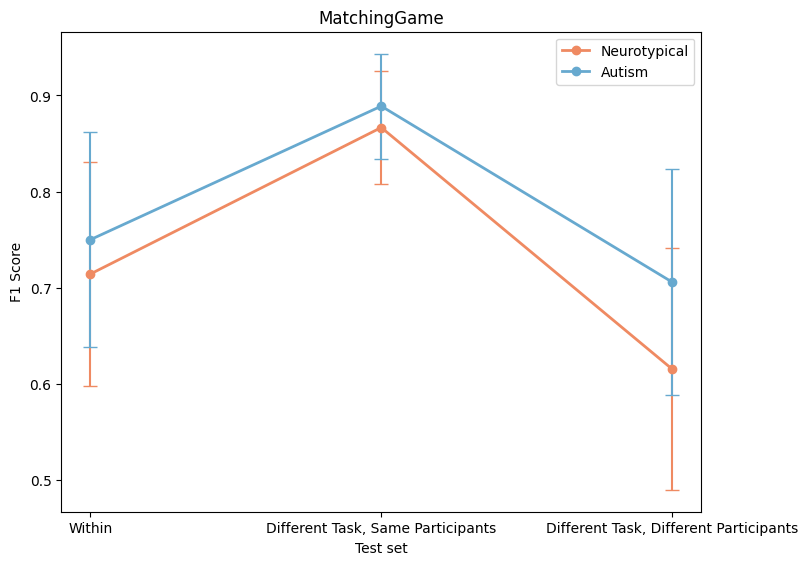

In [9]:
# MatchingGame
plot_values = functions.plot_estimates('MatchingGame', ['MG_MG_20', 'MG_Qfam_80', 'MG_Qfam_20'], new_names = {
    'MG_MG_20': 'Within',
    'MG_Qfam_80': 'Different Task, Same Participants',
    'MG_Qfam_20': 'Different Task, Different Participants'
})
print(tabulate(plot_values, headers='keys', tablefmt='psql'))

functions.plot_results('MatchingGame', plot_values)


+----+-------------------------+--------------+---------------+----------------+-----------+-----------+
|    | test_type               | model_type   |   F1_score_td |   F1_score_asd |     eb_td |    eb_asd |
|----+-------------------------+--------------+---------------+----------------+-----------+-----------|
|  0 | Within                  | xgb          |      0.666667 |       0.777778 | 0.121716  | 0.107344  |
|  3 | Different Task,         | xgb          |      0.8      |       0.833333 | 0.0696311 | 0.0648749 |
|    | Same Participants       |              |               |                |           |           |
|  1 | Different Task,         | xgb          |      0.666667 |       0.777778 | 0.121716  | 0.107344  |
|    | Different Participants  |              |               |                |           |           |
|  4 | Different Familiarity,  | xgb          |      0.714286 |       0.789474 | 0.0786403 | 0.0709684 |
|    | Same Participants       |              |        

/work/bachelor/Python/functions.py:712: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  results['test_type'] = results['test_type'].replace(new_names)


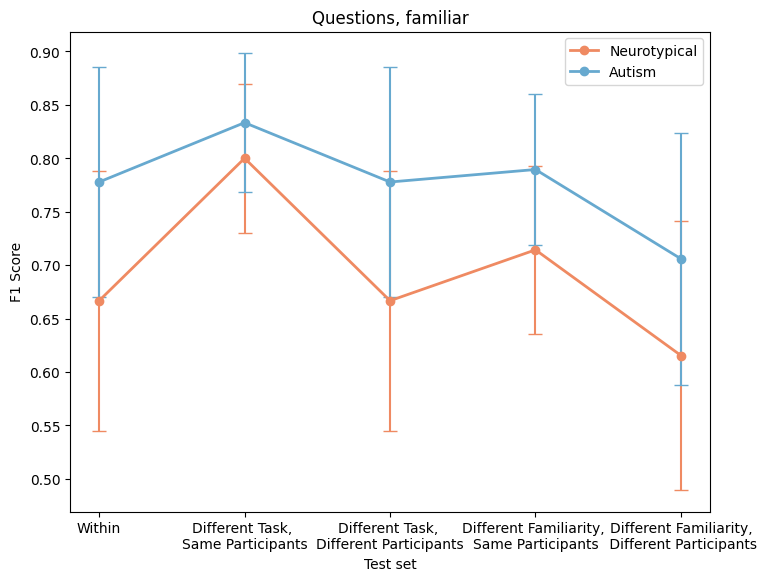

In [11]:
# Qfam
plot_values = functions.plot_estimates('Qfam', ['Qfam_Qfam_20', 'Qfam_MG_80', 'Qfam_MG_20', 'Qfam_Qunfam_80', 'Qfam_Qunfam_20'], new_names = {
    'Qfam_Qfam_20': 'Within',
    'Qfam_MG_80': 'Different Task, \nSame Participants',
    'Qfam_MG_20': 'Different Task, \nDifferent Participants',
    'Qfam_Qunfam_80': 'Different Familiarity, \nSame Participants',
    'Qfam_Qunfam_20': 'Different Familiarity,\n Different Participants'
    })

print(tabulate(plot_values, headers='keys', tablefmt='psql'))
functions.plot_results('Questions, familiar', plot_values)


+----+-------------------------+--------------+---------------+----------------+-----------+-----------+
|    | test_type               | model_type   |   F1_score_td |   F1_score_asd |     eb_td |    eb_asd |
|----+-------------------------+--------------+---------------+----------------+-----------+-----------|
|  2 | Within                  | xgb          |      0.545455 |       0.736842 | 0.128565  | 0.113697  |
|  0 | Different Familiarity,  | xgb          |      0.555556 |       0.833333 | 0.0864999 | 0.0648749 |
|    |  Same Participants      |              |               |                |           |           |
|  1 | Different Familiarity,  | xgb          |      0.222222 |       0.666667 | 0.107344  | 0.121716  |
|    |  Different Participants |              |               |                |           |           |
+----+-------------------------+--------------+---------------+----------------+-----------+-----------+


/work/bachelor/Python/functions.py:712: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  results['test_type'] = results['test_type'].replace(new_names)


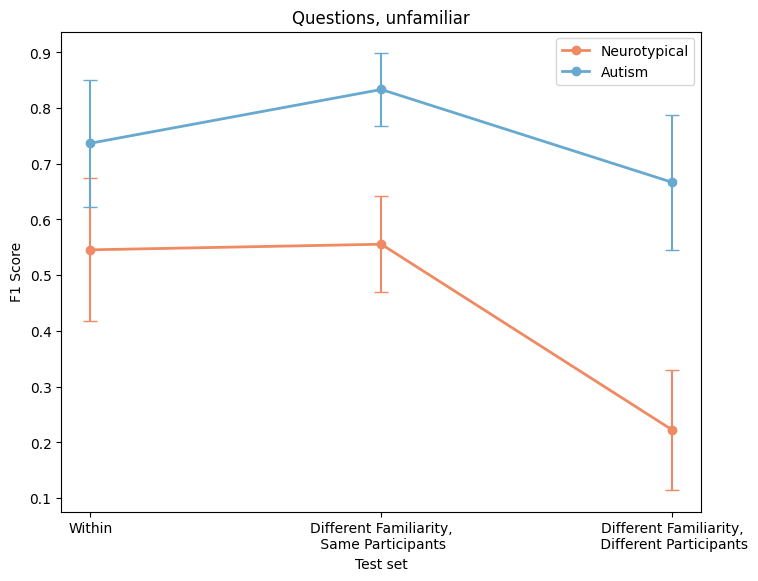

In [10]:
# Qunfam
plot_values = functions.plot_estimates('Qunfam', ['Qunfam_Qunfam_20', 'Qunfam_Qfam_80', 'Qunfam_Qfam_20'], new_names = {
    'Qunfam_Qunfam_20': 'Within',
    'Qunfam_Qfam_80': 'Different Familiarity,\n Same Participants',
    'Qunfam_Qfam_20': 'Different Familiarity,\n Different Participants'
})

print(tabulate(plot_values, headers='keys', tablefmt='psql'))
functions.plot_results('Questions, unfamiliar', plot_values)

In [10]:
MG_Qfam_20_test_xgb = functions.modeltesting2(MG_features,
             MG_Qfam_20,
             'xgb',
             save = False,
             test_name = "MG_Qfam_20",
             train_name = 'MatchingGame')

print(MG_Qfam_20_test_xgb[3])

                  0         1  accuracy  macro avg  weighted avg
precision  0.800000  0.600000  0.666667   0.700000      0.706667
recall     0.500000  0.857143  0.666667   0.678571      0.666667
f1-score   0.615385  0.705882  0.666667   0.660633      0.657617
support    8.000000  7.000000  0.666667  15.000000     15.000000
